# AV02 - Previsão de retornos diários de ações do Ibovespa com LSTM

## Importing data and Python libs

In [68]:
# data
import pandas as pd
import plotly.express as px
from pandas import Timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# math
import numpy as np
import math
from math import floor, ceil
import random

# stats, metrics, model selection
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import kstest, shapiro
from statsmodels.tsa.stattools import adfuller, pacf, acf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer
from sklearn.model_selection import train_test_split, TimeSeriesSplit, BaseCrossValidator, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler

# models
# import pmdarima as pm
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Input, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

RANDOM_STATE = 21

np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)


In [69]:
abev3 = pd.read_csv("./av02_lstm/stocks/ABEV3.csv")
bbdc3 = pd.read_csv("./av02_lstm/stocks/BBDC3.csv")
itsa3 = pd.read_csv("./av02_lstm/stocks/ITSA3.csv")
itub3 = pd.read_csv("./av02_lstm/stocks/ITUB3.csv")
wege3 = pd.read_csv("./av02_lstm/stocks/WEGE3.csv")

In [70]:
abev3.head()

Date  Price   Open   High    Low    Vol. Change %
0  10/04/2024  13.28  13.26  13.45  13.17  36.59M   -0.90%
1  10/03/2024  13.40  13.55  13.63  13.40  44.99M   -2.33%
2  10/02/2024  13.72  13.70  13.85  13.61  51.03M    0.88%
3  10/01/2024  13.60  13.20  13.72  13.13  65.79M    3.98%
4  09/30/2024  13.08  12.94  13.17  12.90  31.05M    1.24%

In [71]:
bbdc3.head()

Date  Price   Open   High    Low   Vol. Change %
0  10/04/2024  13.29  13.19  13.42  13.10  5.32M    0.30%
1  10/03/2024  13.25  13.28  13.42  13.14  5.28M   -0.97%
2  10/02/2024  13.38  13.30  13.54  13.27  8.59M    3.22%
3  10/01/2024  12.96  13.04  13.11  12.84  7.16M    0.54%
4  09/30/2024  12.89  13.05  13.08  12.87  5.90M   -1.13%

In [72]:
itsa3.head()

Date  Price   Open   High    Low     Vol. Change %
0  10/04/2024  10.63  10.57  10.68  10.55  114.10K    0.76%
1  10/03/2024  10.55  10.91  10.91  10.55  294.10K   -3.21%
2  10/02/2024  10.90  10.90  11.05  10.90  162.60K    0.46%
3  10/01/2024  10.85  11.07  11.07  10.79  432.30K   -2.08%
4  09/30/2024  11.08  11.12  11.16  11.00  122.70K   -0.63%

In [73]:
itub3.head()

Date  Price   Open   High    Low     Vol. Change %
0  10/04/2024  30.46  30.39  30.60  30.27  310.50K    0.20%
1  10/03/2024  30.40  31.01  31.02  30.30  386.90K   -2.22%
2  10/02/2024  31.09  30.90  31.43  30.90  343.80K    0.65%
3  10/01/2024  30.89  31.41  31.49  30.77  467.50K   -1.66%
4  09/30/2024  31.41  31.86  32.01  31.41  428.40K   -1.50%

In [74]:
wege3.head()

Date  Price   Open   High    Low   Vol. Change %
0  10/04/2024  54.50  54.36  54.98  54.26  4.82M   -0.18%
1  10/03/2024  54.60  54.76  55.00  53.95  4.47M   -1.36%
2  10/02/2024  55.35  56.13  56.37  55.14  5.12M   -0.95%
3  10/01/2024  55.88  55.00  56.22  54.80  8.03M    2.74%
4  09/30/2024  54.39  55.63  56.24  54.39  6.41M   -2.81%

Filtrando dataframes e convertendo data em Index

In [75]:
START_DATE = "2007-10-04" # first register of price for WEGE3
END_DATE = "2024-10-04"

In [76]:
abev3 = abev3.filter(["Date", "Price"], axis=1)
bbdc3 = bbdc3.filter(["Date", "Price"], axis=1)
itsa3 = itsa3.filter(["Date", "Price"], axis=1)
itub3 = itub3.filter(["Date", "Price"], axis=1)
wege3 = wege3.filter(["Date", "Price"], axis=1)

abev3['Date'] = pd.to_datetime(abev3['Date'], format='%m/%d/%Y')
bbdc3['Date'] = pd.to_datetime(bbdc3['Date'], format='%m/%d/%Y')
itsa3['Date'] = pd.to_datetime(itsa3['Date'], format='%m/%d/%Y')
itub3['Date'] = pd.to_datetime(itub3['Date'], format='%m/%d/%Y')
wege3['Date'] = pd.to_datetime(wege3['Date'], format='%m/%d/%Y')

In [77]:
abev3.head()

Date  Price
0 2024-10-04  13.28
1 2024-10-03  13.40
2 2024-10-02  13.72
3 2024-10-01  13.60
4 2024-09-30  13.08

In [78]:
abev3 = abev3[(abev3["Date"] >= START_DATE) & (abev3["Date"] <= END_DATE)]
abev3.tail()

Date  Price
4210 2007-10-10   3.04
4211 2007-10-09   3.08
4212 2007-10-08   3.06
4213 2007-10-05   3.06
4214 2007-10-04   2.99

In [79]:
bbdc3 = bbdc3[(bbdc3["Date"] >= START_DATE) & (bbdc3["Date"] <= END_DATE)]
bbdc3.tail()

Date  Price
4211 2007-10-10   6.35
4212 2007-10-09   6.38
4213 2007-10-08   6.31
4214 2007-10-05   6.30
4215 2007-10-04   6.00

In [80]:
itsa3 = itsa3[(itsa3["Date"] >= START_DATE) & (itsa3["Date"] <= END_DATE)]
itsa3.tail()

Date  Price
4151 2007-10-10   3.43
4152 2007-10-09   3.44
4153 2007-10-08   3.43
4154 2007-10-05   3.52
4155 2007-10-04   3.48

In [81]:
itub3 = itub3[(itub3["Date"] >= START_DATE) & (itub3["Date"] <= END_DATE)]
itub3.tail()

Date  Price
4210 2007-10-10   8.15
4211 2007-10-09   8.30
4212 2007-10-08   7.95
4213 2007-10-05   7.86
4214 2007-10-04   7.44

In [82]:
wege3 = wege3[(wege3["Date"] >= START_DATE) & (wege3["Date"] <= END_DATE)]
wege3.tail()

Date  Price
4210 2007-10-10   2.43
4211 2007-10-09   2.44
4212 2007-10-08   2.45
4213 2007-10-05   2.43
4214 2007-10-04   2.40

In [83]:
for i in abev3["Date"].diff(-1):
    if i > Timedelta('4 days'):
        print(i)

5 days 00:00:00
5 days 00:00:00
5 days 00:00:00
5 days 00:00:00
5 days 00:00:00
5 days 00:00:00
5 days 00:00:00
5 days 00:00:00
5 days 00:00:00
5 days 00:00:00
5 days 00:00:00
5 days 00:00:00
5 days 00:00:00
5 days 00:00:00
5 days 00:00:00
5 days 00:00:00
5 days 00:00:00
5 days 00:00:00
5 days 00:00:00
5 days 00:00:00
5 days 00:00:00
5 days 00:00:00
5 days 00:00:00
5 days 00:00:00
5 days 00:00:00
5 days 00:00:00
5 days 00:00:00
5 days 00:00:00
5 days 00:00:00
5 days 00:00:00
5 days 00:00:00
5 days 00:00:00
5 days 00:00:00


In [84]:
abev3.set_index('Date', inplace=True)
bbdc3.set_index('Date', inplace=True)
itsa3.set_index('Date', inplace=True)
itub3.set_index('Date', inplace=True)
wege3.set_index('Date', inplace=True)

In [85]:
def print_line_series(df: pd.DataFrame):
    plt.figure(figsize=(30, 10))
    plt.plot(df.Price)

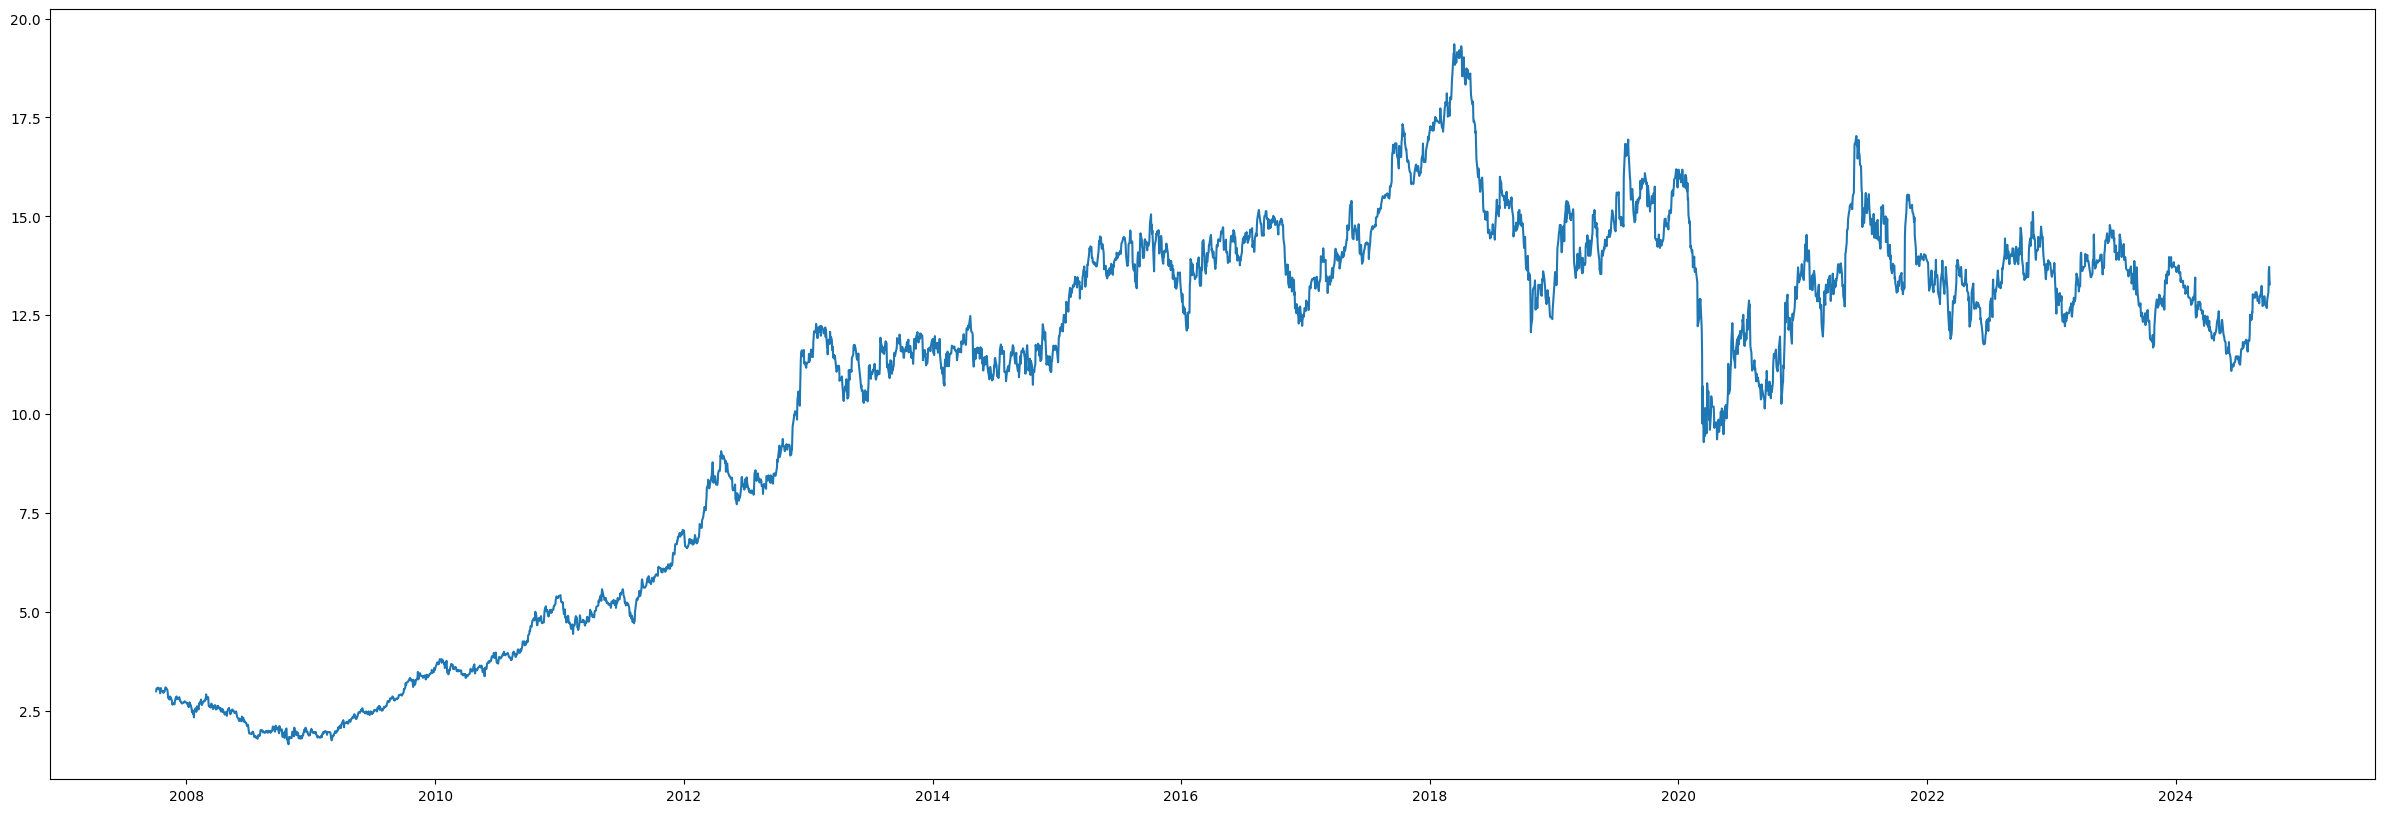

In [86]:
print_line_series(abev3)

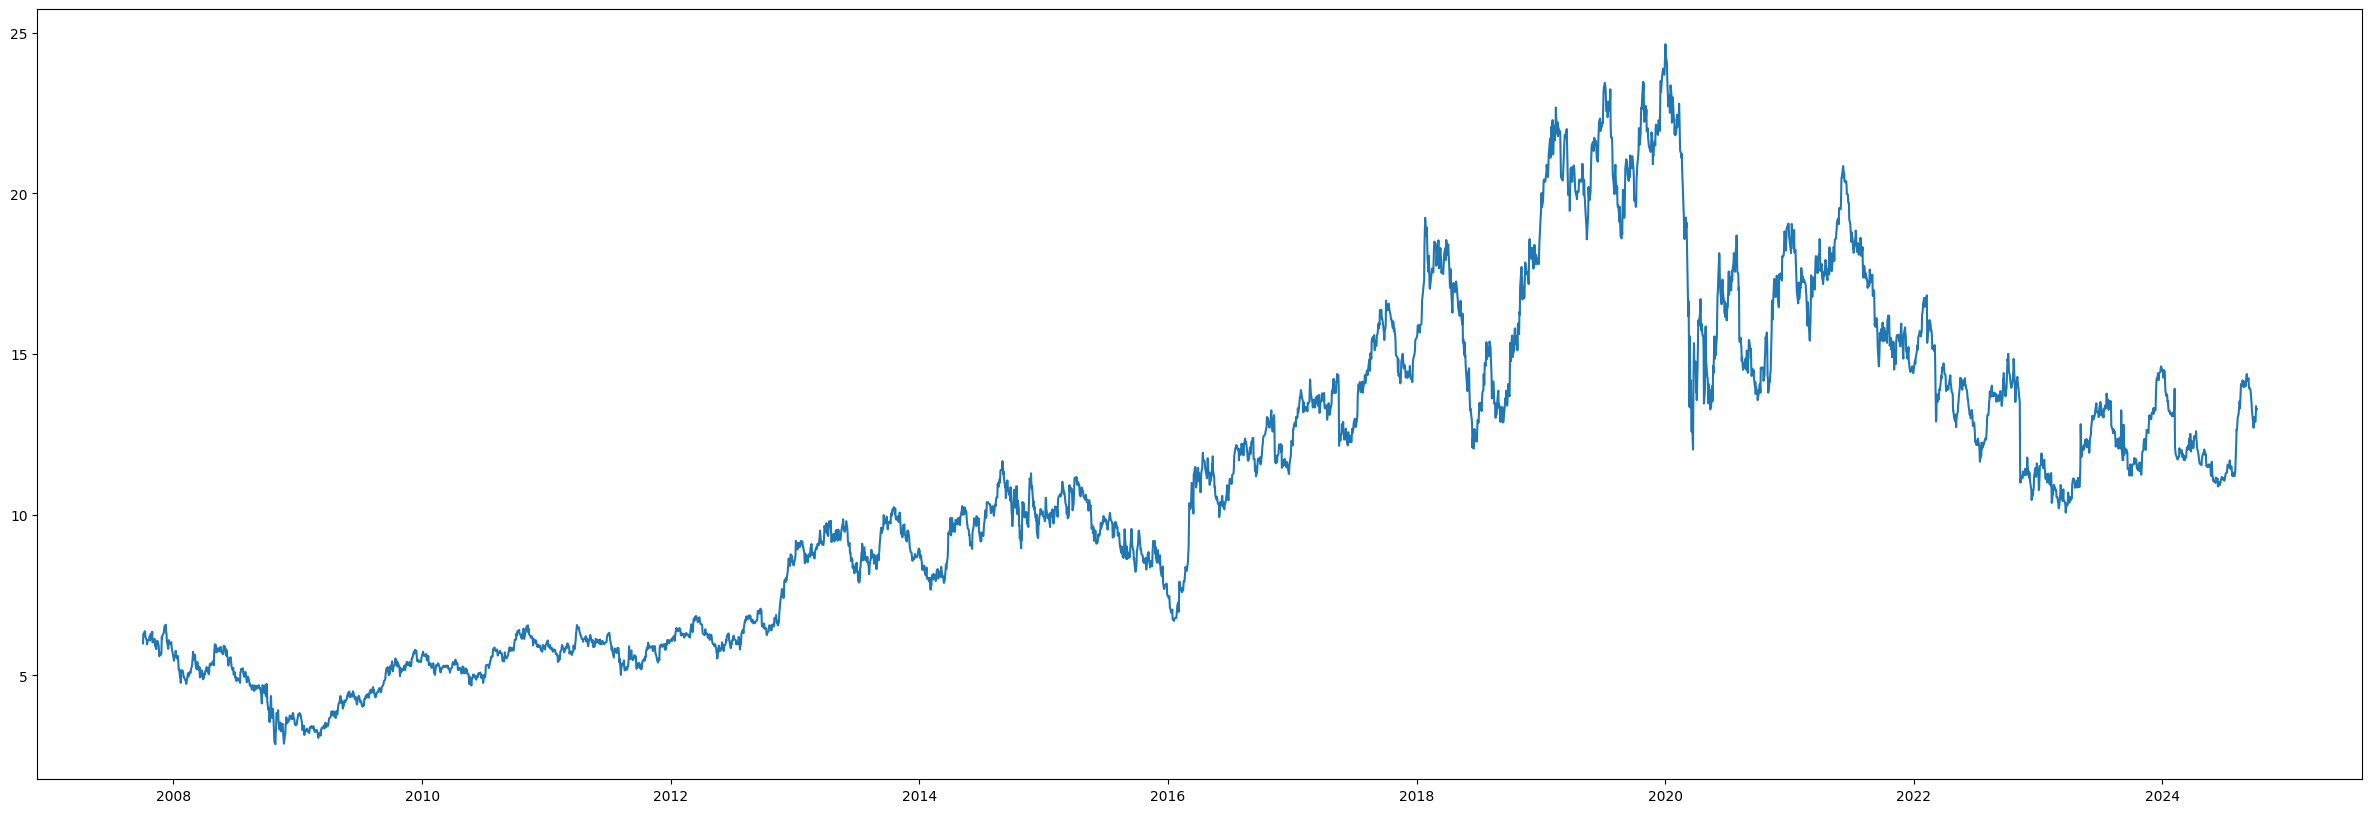

In [87]:
print_line_series(bbdc3)

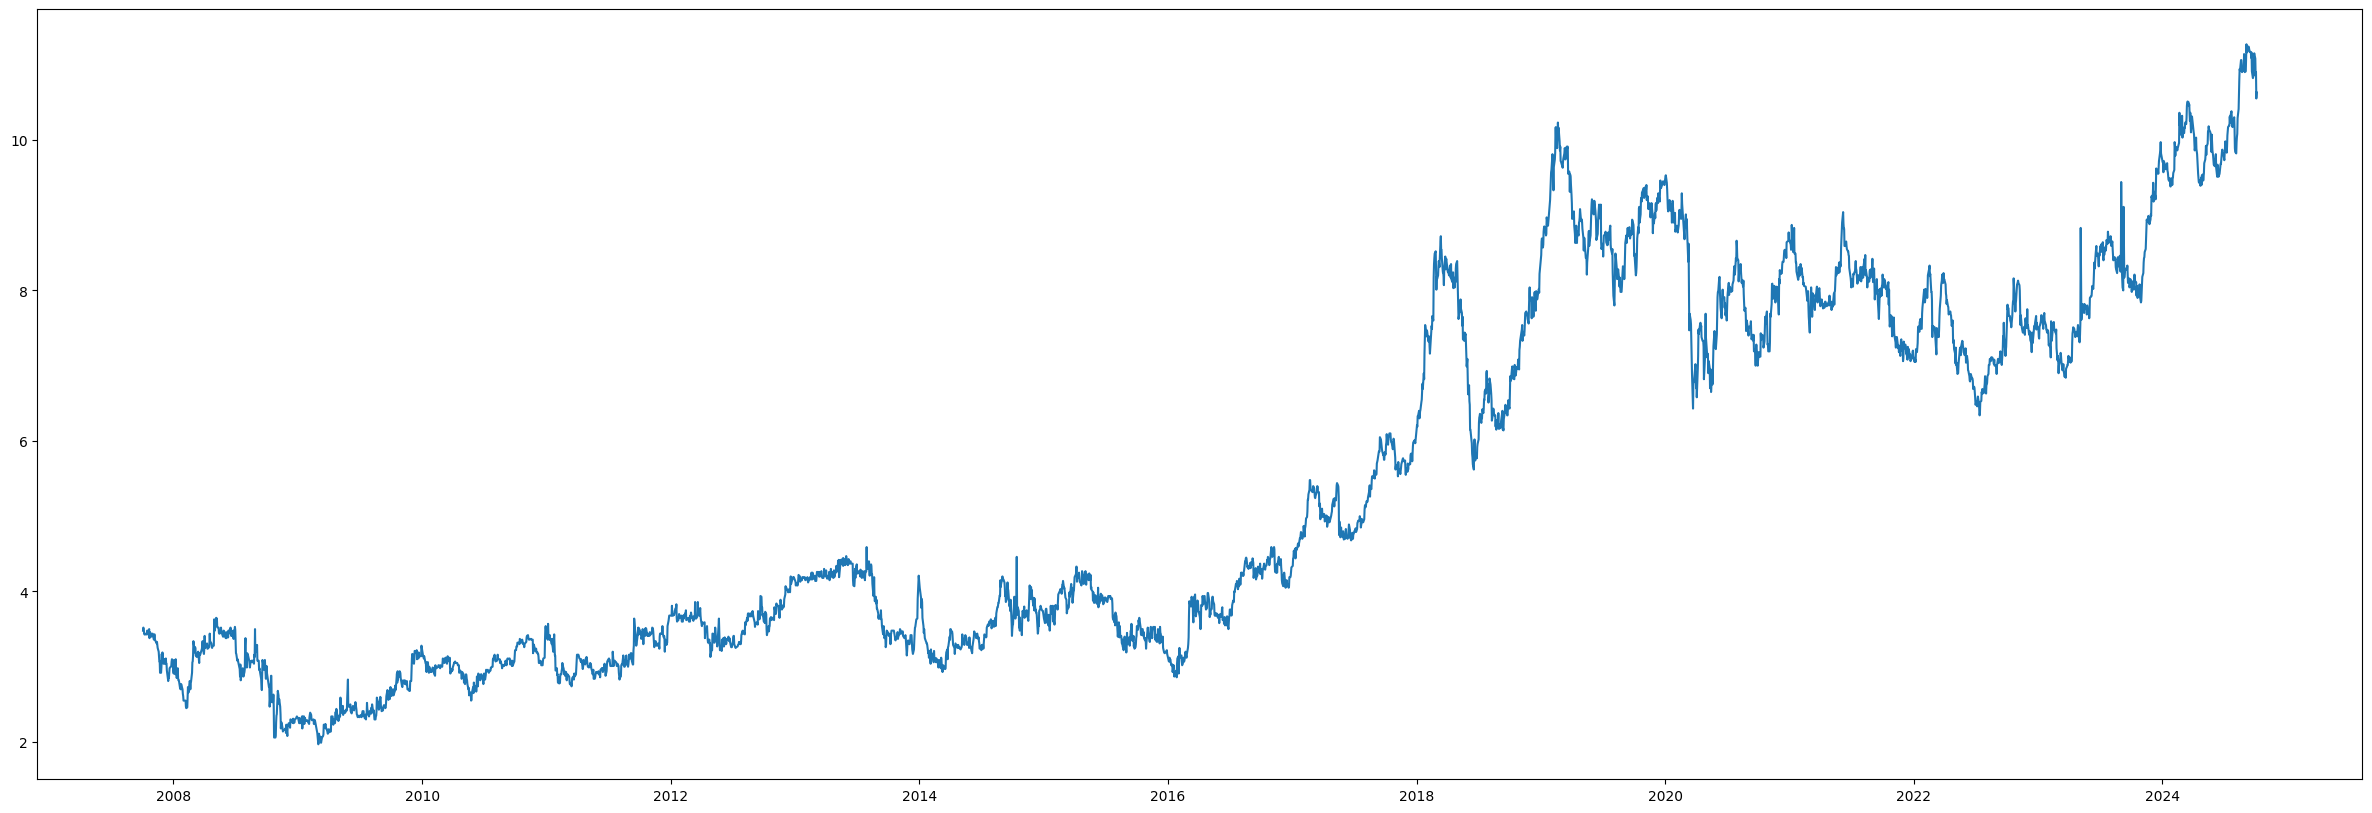

In [88]:
print_line_series(itsa3)

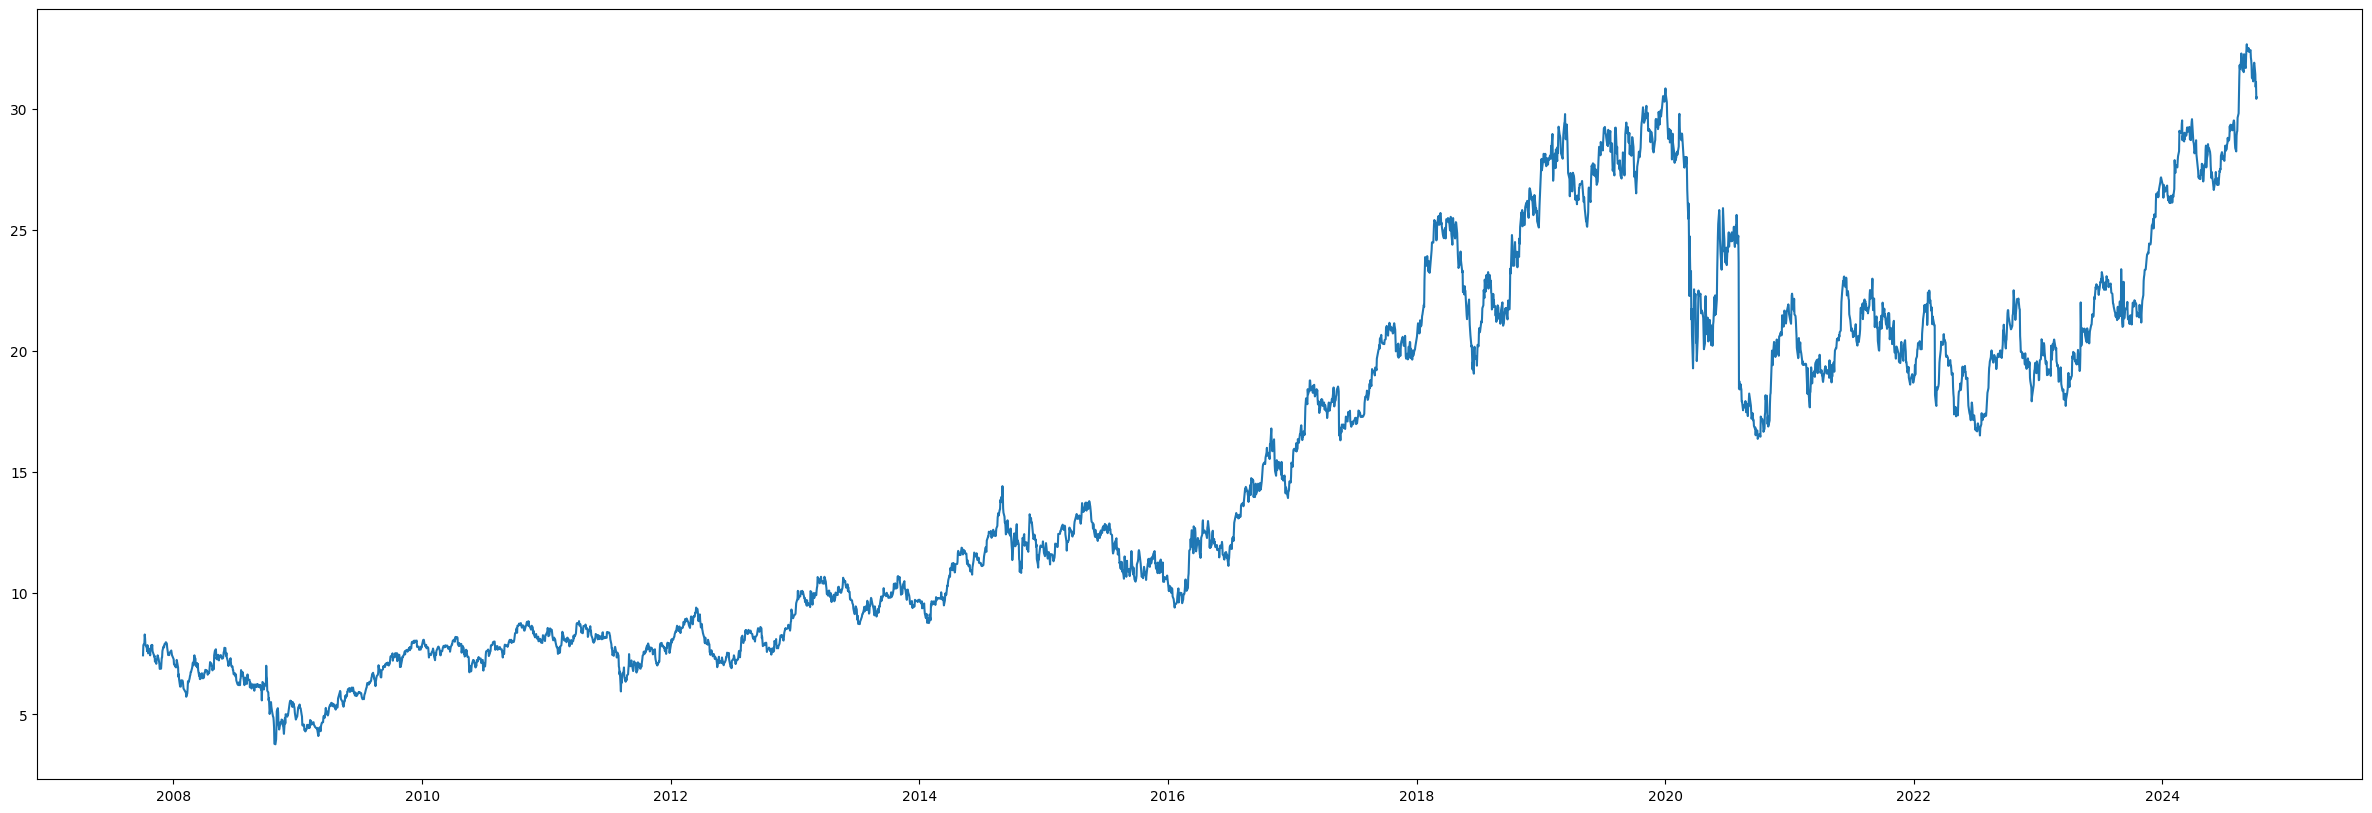

In [89]:
print_line_series(itub3)

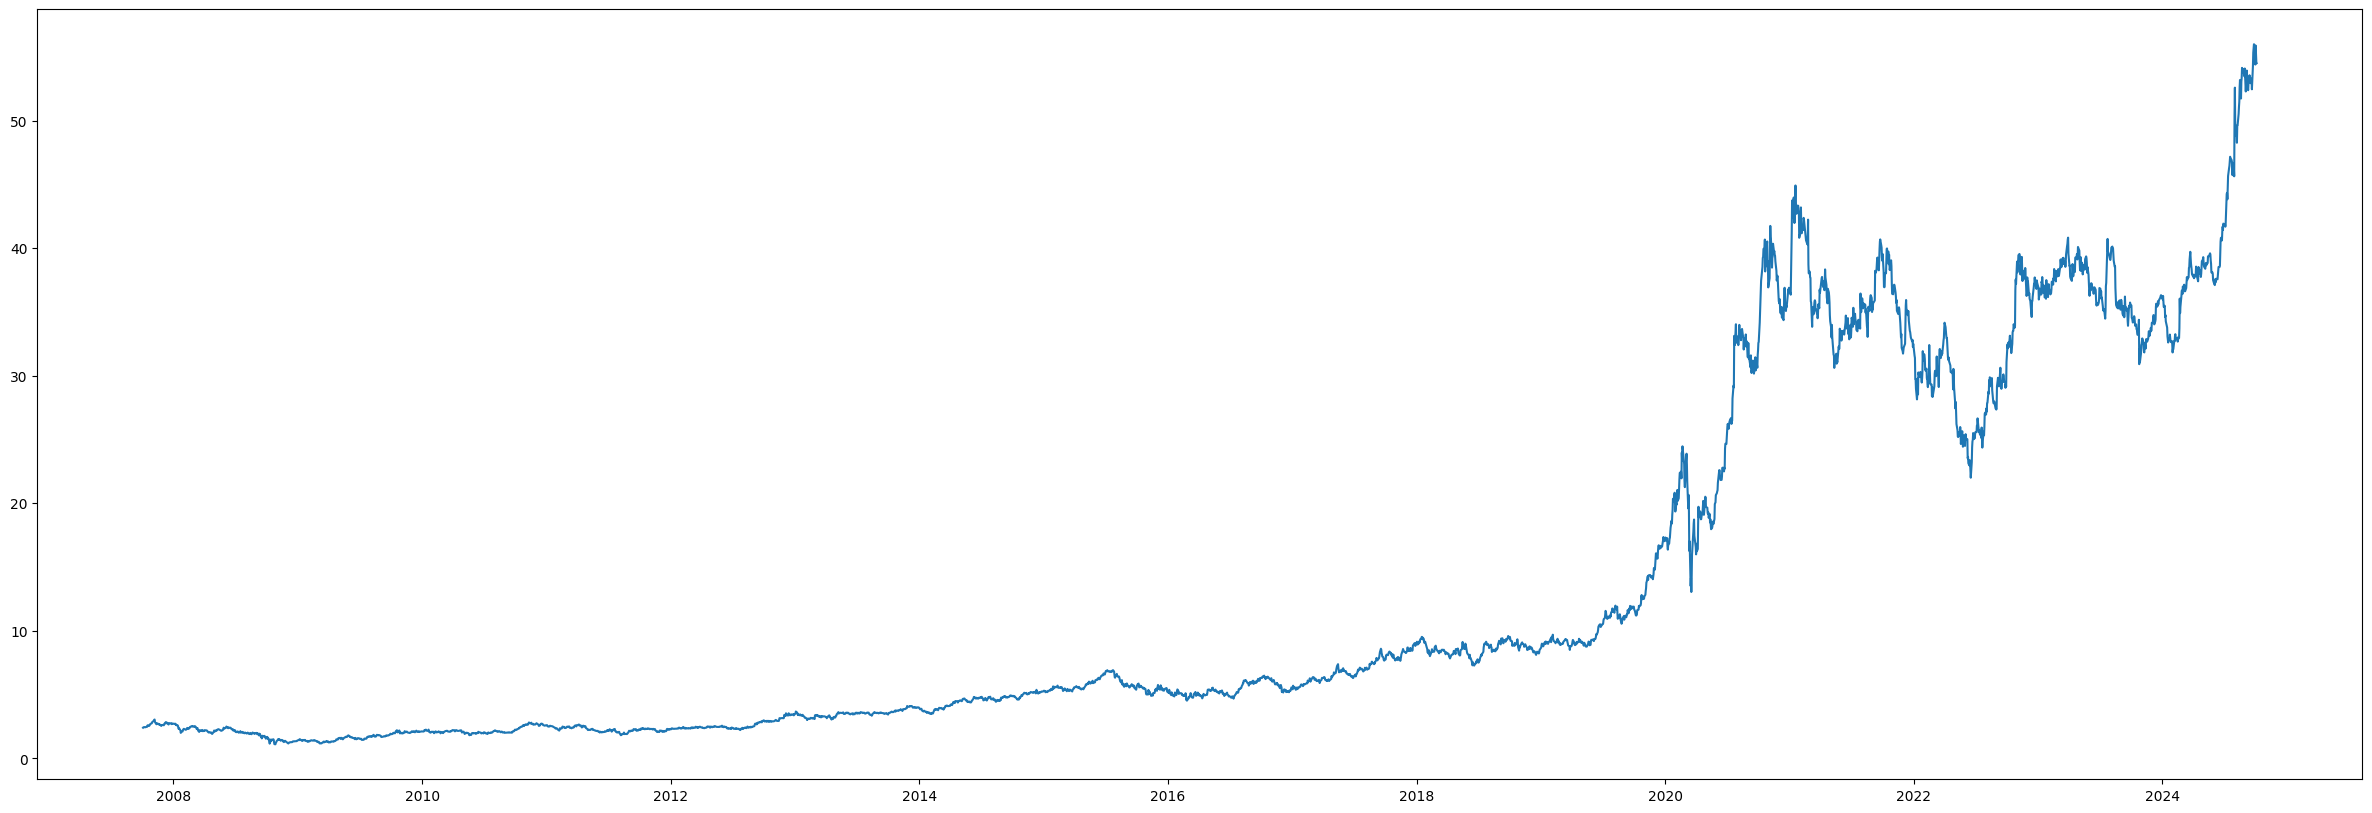

In [90]:
print_line_series(wege3)

## Lidando com dados faltantes

In [91]:
abev3.isna().sum()

Price    0
dtype: int64

In [92]:
bbdc3.isna().sum()

Price    0
dtype: int64

In [93]:
itsa3.isna().sum()

Price    0
dtype: int64

In [94]:
itub3.isna().sum()

Price    0
dtype: int64

In [95]:
wege3.isna().sum()

Price    0
dtype: int64

In [96]:
print(len(abev3))
print(len(bbdc3))
print(len(itub3))
print(len(itsa3))
print(len(wege3))

4215
4216
4215
4156
4215


In [97]:
stocks_df = pd.concat(
    [
        abev3.add_suffix("_abev3"), 
        bbdc3.add_suffix("_bbdc3"), 
        itub3.add_suffix("_itub3"), 
        itsa3.add_suffix("_itsa3"), 
        wege3.add_suffix("_wege3")
    ], 
    axis=1
)
stocks_df.head(10)

Price_abev3  Price_bbdc3  Price_itub3  Price_itsa3  Price_wege3
Date                                                                       
2007-10-04         2.99         6.00         7.44         3.48         2.40
2007-10-05         3.06         6.30         7.86         3.52         2.43
2007-10-08         3.06         6.31         7.95         3.43         2.45
2007-10-09         3.08         6.38         8.30         3.44         2.44
2007-10-10         3.04         6.35         8.15         3.43         2.43
2007-10-11         3.08         6.20         7.87         3.43         2.44
2007-10-15         3.02         6.09         7.75         3.43         2.47
2007-10-16         2.94         5.97         7.61         3.48         2.47
2007-10-17         3.06         6.09         7.86         3.48         2.57
2007-10-18         3.07         6.09          NaN         3.48         2.59

In [98]:
stocks_df.isna().sum()

Price_abev3     1
Price_bbdc3     0
Price_itub3     1
Price_itsa3    60
Price_wege3     1
dtype: int64

In [99]:
def count_largest_missing_interval(df: pd.DataFrame, column: str):
    # Step 1: Create a mask for missing values in the specified column.
    mask = df[column].isna()

    # Step 2: Identify consecutive groups of NaNs using cumsum on the inverted mask.
    # Use (~mask).cumsum() to create a unique group number for consecutive NaNs.
    groups = (~mask).cumsum()

    # Step 3: Filter only the groups corresponding to NaN values.
    nan_groups = stocks_df[mask].groupby(groups).size()

    # Step 4: Find the maximum size of consecutive NaNs.
    max_nan_sequence_length = nan_groups.max() if not nan_groups.empty else 0

    # Step 5: Get the index range for this sequence if it exists.
    if max_nan_sequence_length > 0:
        longest_nan_group = nan_groups.idxmax()
        start_date = df[mask & (groups == longest_nan_group)].index.min()
        end_date = df[mask & (groups == longest_nan_group)].index.max()
        print(f"The length of the largest consecutive sequence of missing values in {column} is: {max_nan_sequence_length}")
        print(f"The time range for this sequence is from {start_date} to {end_date}")
    else:
        print(f"No missing values found in the {column} time series.")
    print("\n")


In [100]:
for col in [col for col in stocks_df.columns.tolist() if "Price_" in col]:
    count_largest_missing_interval(stocks_df, col)

The length of the largest consecutive sequence of missing values in Price_abev3 is: 1
The time range for this sequence is from 2024-05-25 00:00:00 to 2024-05-25 00:00:00


No missing values found in the Price_bbdc3 time series.


The length of the largest consecutive sequence of missing values in Price_itub3 is: 1
The time range for this sequence is from 2007-10-18 00:00:00 to 2007-10-18 00:00:00


The length of the largest consecutive sequence of missing values in Price_itsa3 is: 3
The time range for this sequence is from 2008-10-03 00:00:00 to 2008-10-07 00:00:00


The length of the largest consecutive sequence of missing values in Price_wege3 is: 1
The time range for this sequence is from 2024-05-25 00:00:00 to 2024-05-25 00:00:00




Considerando que a série de preços de ações se comporta de forma semelhante a passeios aleatórios com inclinação positiva, a suposição de que o melhor modelo para prever o próximo passo é repetir o anterior não se aplica. Nesse caso, será aplicada uma interpolação linear, considerando que os valores ausentes não constituem intervalos maiores que 3 valores sequenciais. https://people.duke.edu/~rnau/Notes_on_the_random_walk_model--Robert_Nau.pdf


In [101]:
stocks_df = stocks_df.interpolate(method="linear")

In [102]:
stocks_df.isna().sum()

Price_abev3    0
Price_bbdc3    0
Price_itub3    0
Price_itsa3    0
Price_wege3    0
dtype: int64

## Exploração

In [103]:
def compute_returns_for_prices(df: pd.DataFrame, column_names: list[str]):
    for column in column_names:
        new_name = column.split("_")[1]
        df[f"Return_{new_name}"] = (df[column] / df[column].shift(1)) - 1
        df.dropna(inplace=True)

In [104]:
def normal_komolgorov_smirnov(array: np.ndarray):
    ks_statistic, p_value = kstest(array, 'norm')

    print(f"KS Statistic: {ks_statistic}")
    print(f"P-Value: {p_value}")

    if p_value < 0.05:
        print("H0 rejected, distribution can't be said Normal")
    else:
        print("H0 is not rejected, possibly normal distribution")
    
    return ks_statistic, p_value

In [105]:
def shapiro_wilk_gaussian_test(array: np.ndarray):
    sw_stat, p_value = shapiro(array)

    print(f"Shapiro-Wilk Statistic: {sw_stat}")
    print(f"P-Value: {p_value}")

    if p_value < 0.05:
        print("H0 rejected, distribution can't be said Normal")
    else:
        print("Fail to reject H0, possibly normal distribution")
    
    return sw_stat, p_value

In [106]:
def adf_test(array: np.ndarray):
    result = adfuller(array)

    adf_stat = result[0]
    p_value = result[1]
    critical_values = result[4]

    # Extract and print the test statistic, p-value, and critical values
    print('ADF Statistic:', adf_stat)
    print('p-value:', p_value)
    print('Critical Values:')
    crit5 = None
    for key, value in critical_values.items():
        if key == '5%':
            crit5 = value
        print(f'   {key}: {value}')
    print("\n")

    if p_value < 0.05:
        print("H0 rejected. Series is possibly stationary")
    else:
        print("H0 not rejected. Series is possibly non-stationary")

    return adf_stat, p_value

In [107]:
compute_returns_for_prices(stocks_df, stocks_df.columns.tolist())
stocks_df.tail()

Price_abev3  Price_bbdc3  Price_itub3  Price_itsa3  Price_wege3  \
Date                                                                          
2024-09-30        13.08        12.89        31.41        11.08        54.39   
2024-10-01        13.60        12.96        30.89        10.85        55.88   
2024-10-02        13.72        13.38        31.09        10.90        55.35   
2024-10-03        13.40        13.25        30.40        10.55        54.60   
2024-10-04        13.28        13.29        30.46        10.63        54.50   

            Return_abev3  Return_bbdc3  Return_itub3  Return_itsa3  \
Date                                                                 
2024-09-30      0.012384     -0.011503     -0.015052     -0.006278   
2024-10-01      0.039755      0.005431     -0.016555     -0.020758   
2024-10-02      0.008824      0.032407      0.006475      0.004608   
2024-10-03     -0.023324     -0.009716     -0.022194     -0.032110   
2024-10-04     -0.008955      0.003019      0.001974      0.007583   

            Return_wege3  
Date                      
2024-09-30     -0.028056  
2024-10-01      0.027395  
2024-10-02     -0.009485  
2024-10-03     -0.013550  
2024-10-04     -0.001832

ADF Statistic: -11.426433608419892
p-value: 6.6778425989564035e-21
Critical Values:
   1%: -3.431915013004786
   5%: -2.862231536705791
   10%: -2.5671381109420808


H0 rejected. Series is possibly stationary
ADF Statistic: -28.64469502096608
p-value: 0.0
Critical Values:
   1%: -3.4319060752453483
   5%: -2.862227588385493
   10%: -2.567136009040254


H0 rejected. Series is possibly stationary
ADF Statistic: -29.548670457689425
p-value: 0.0
Critical Values:
   1%: -3.4319060752453483
   5%: -2.862227588385493
   10%: -2.567136009040254


H0 rejected. Series is possibly stationary
ADF Statistic: -26.054275337285365
p-value: 0.0
Critical Values:
   1%: -3.4319064456133153
   5%: -2.862227751998474
   10%: -2.567136096140145


H0 rejected. Series is possibly stationary
ADF Statistic: -13.788318518029147
p-value: 9.024511198358138e-26
Critical Values:
   1%: -3.4319131425147202
   5%: -2.8622307104041673
   10%: -2.5671376710574165


H0 rejected. Series is possibly stationary


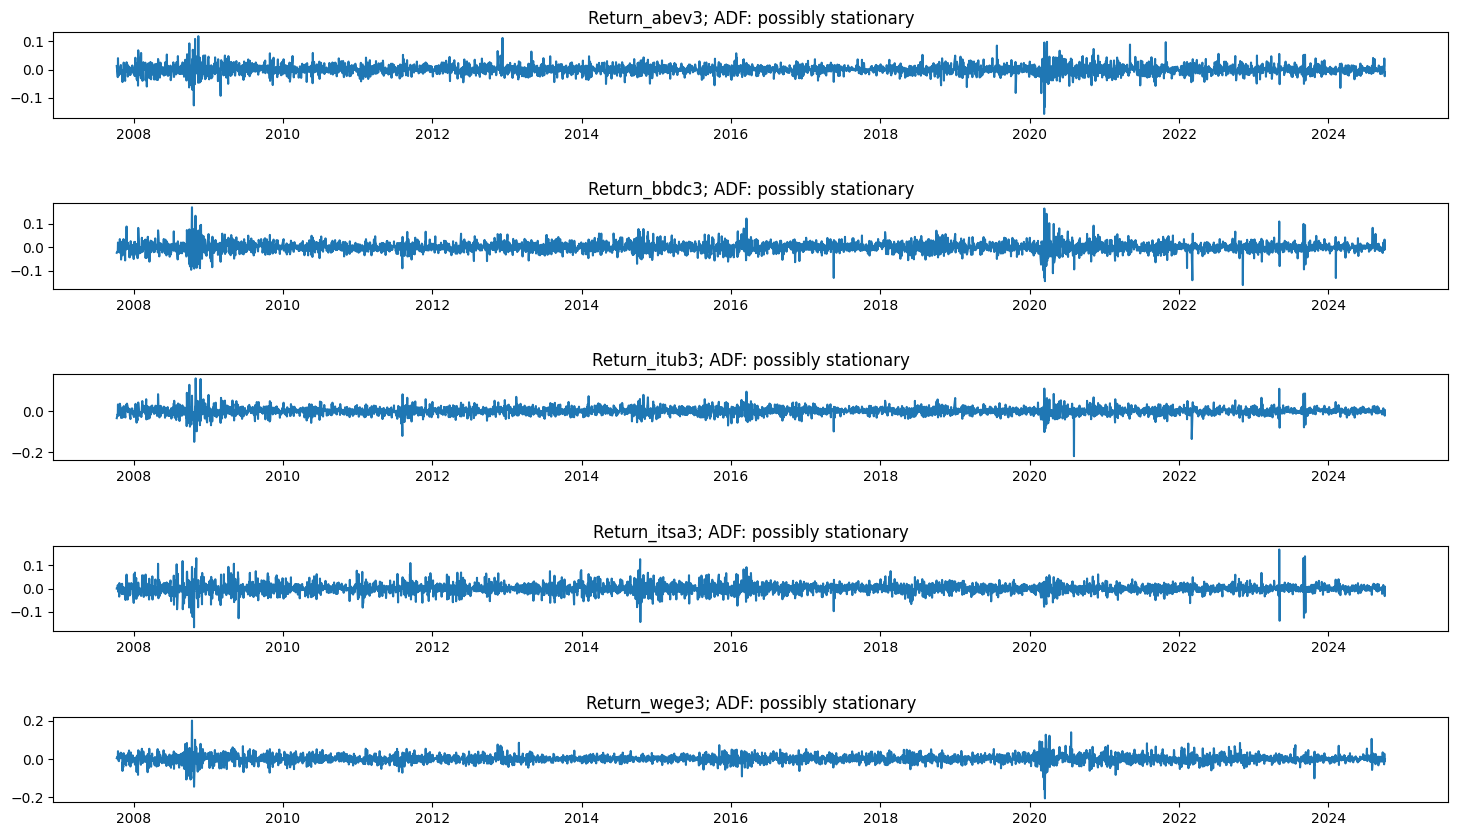

In [108]:
plt.figure(figsize=(18, 10))
for i, col in enumerate([col for col in stocks_df.columns.tolist() if "Return_" in col]):

    _, p_value = adf_test(stocks_df[col])

    plt.subplot(5, 1, i+1)
    plt.axis(True)
    plt.plot(stocks_df[col])
    plt.title(f"{col}; ADF: {'possibly stationary' if p_value < 0.05 else 'possibly non-stationary'}")
    plt.subplots_adjust(wspace=0.2, hspace=1.0)

Shapiro-Wilk Statistic: 0.9404390537904099
P-Value: 3.4647563709884783e-38
H0 rejected, distribution can't be said Normal
Shapiro-Wilk Statistic: 0.9348584346672099
P-Value: 1.6368725473086994e-39
H0 rejected, distribution can't be said Normal
Shapiro-Wilk Statistic: 0.9282626379345048
P-Value: 5.755061300776523e-41
H0 rejected, distribution can't be said Normal
Shapiro-Wilk Statistic: 0.931483355858057
P-Value: 2.8571418135978773e-40
H0 rejected, distribution can't be said Normal
Shapiro-Wilk Statistic: 0.9387578092862793
P-Value: 1.3495297286205933e-38
H0 rejected, distribution can't be said Normal


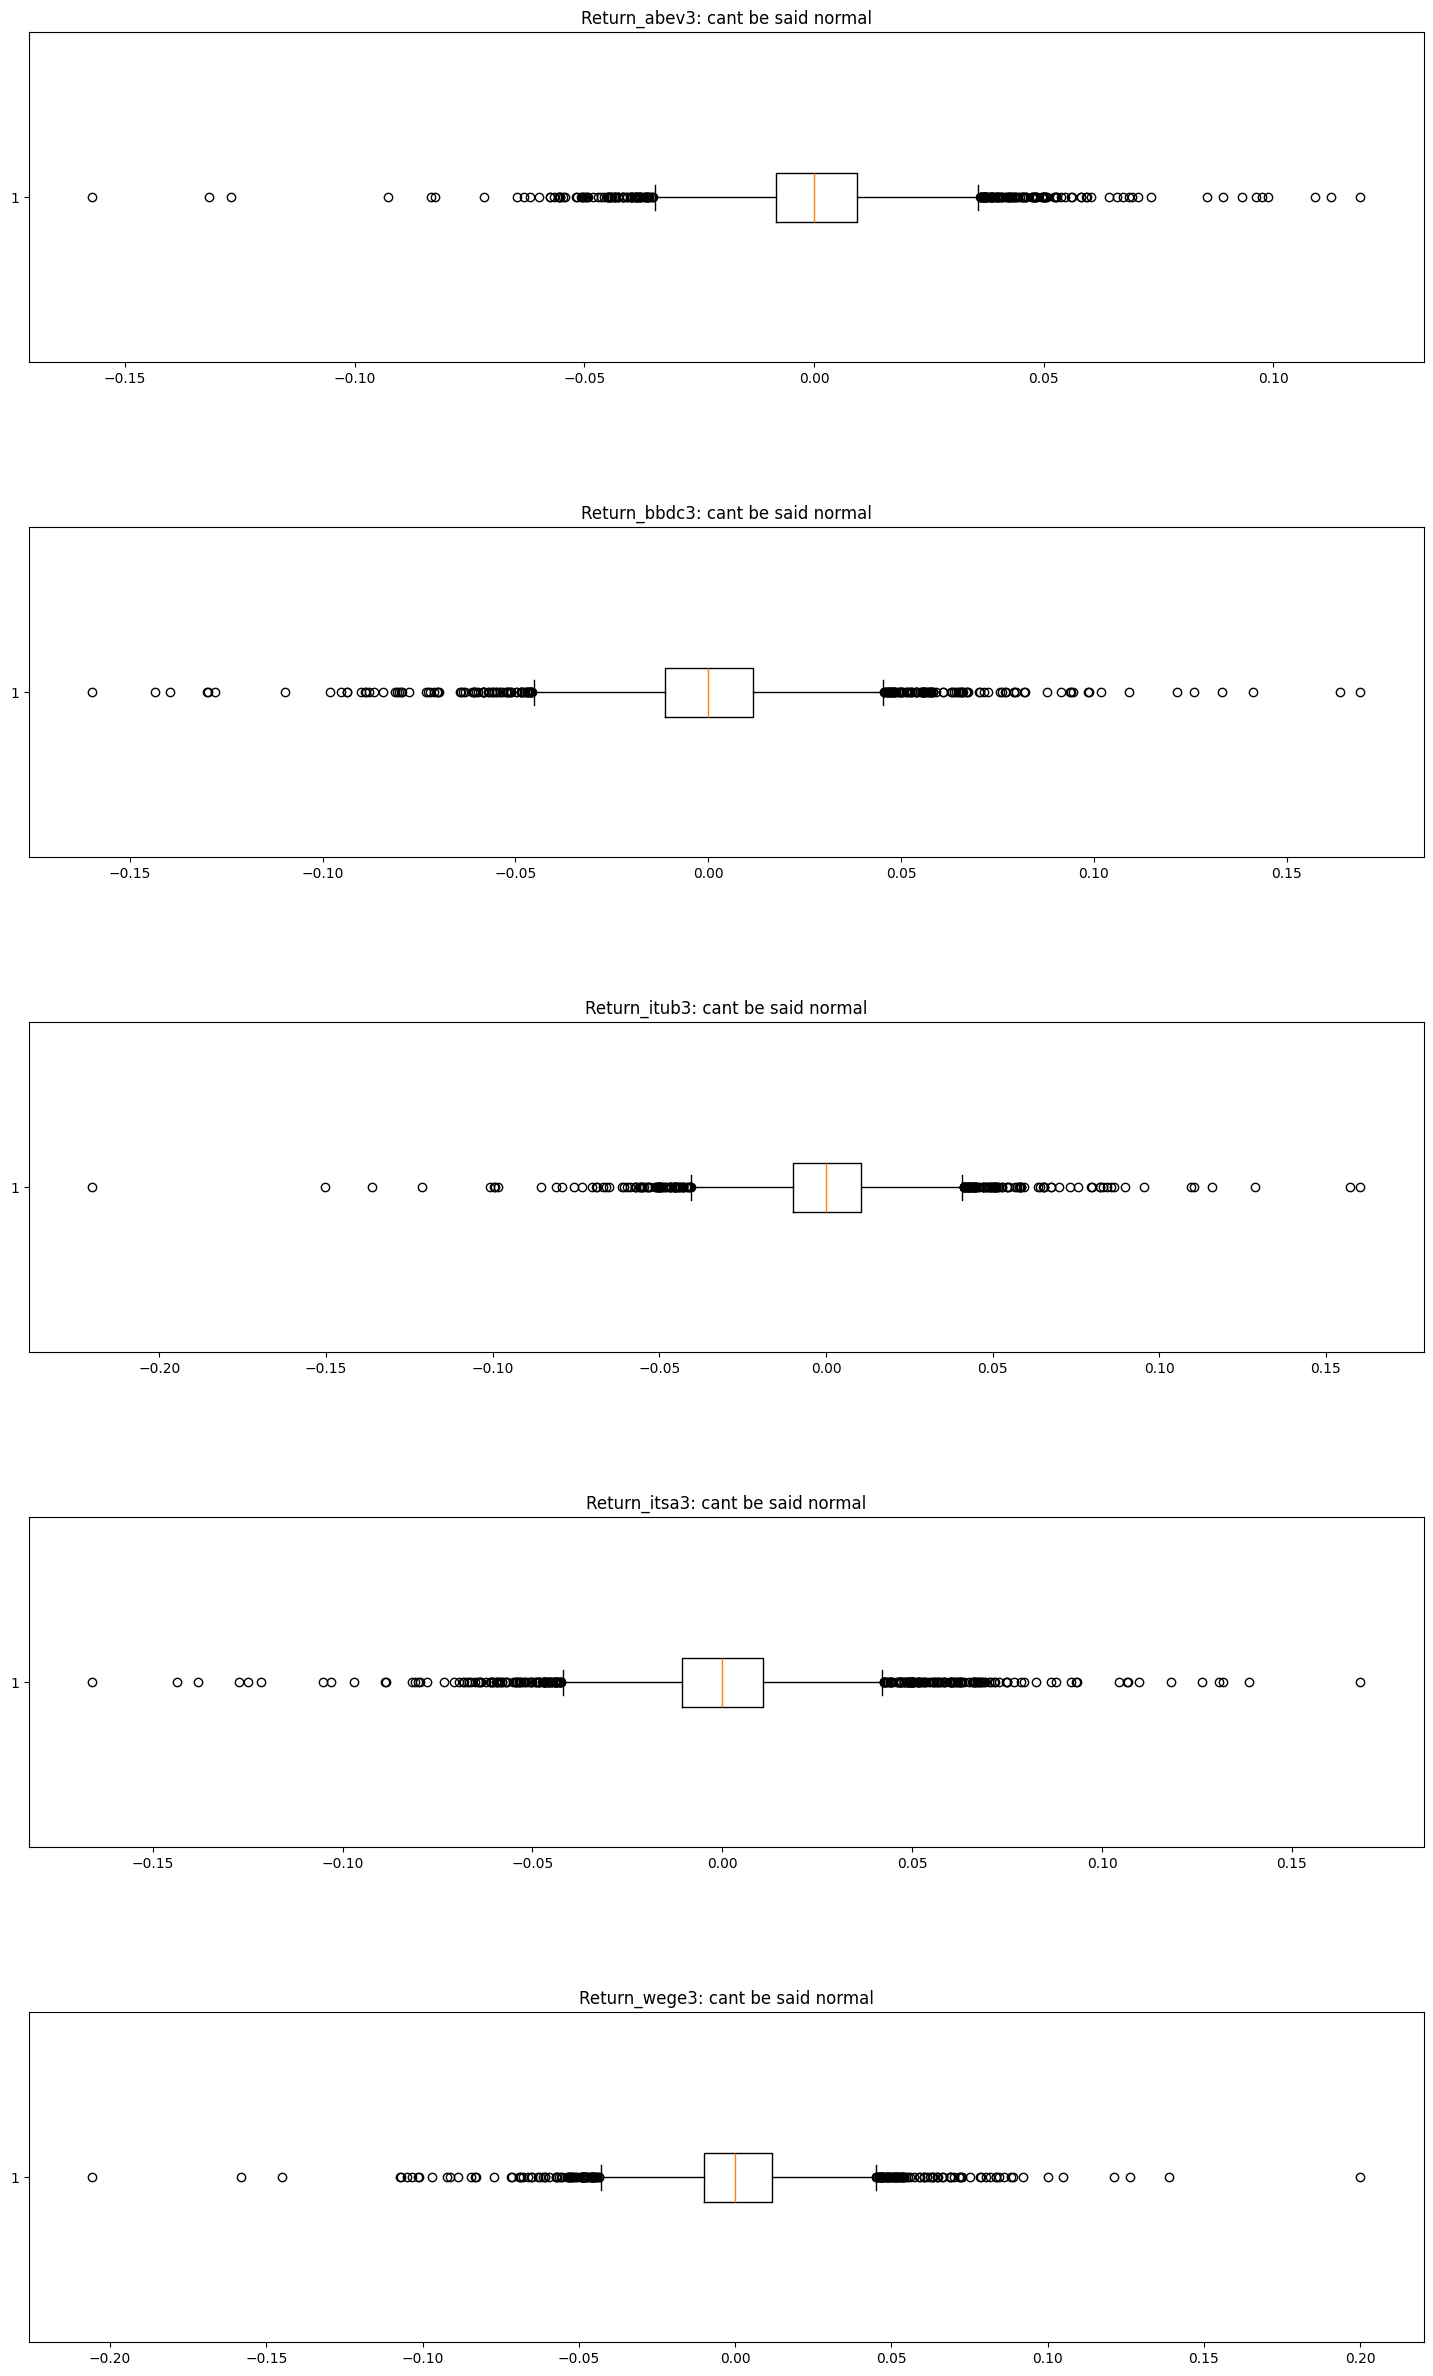

In [109]:
plt.figure(figsize=(18, 30))
for i, col in enumerate([col for col in stocks_df.columns.tolist() if "Return_" in col]):

    _, p_value = shapiro_wilk_gaussian_test(stocks_df[col])

    plt.subplot(5, 1, i+1)
    plt.axis(True)
    plt.boxplot(stocks_df[col], vert=False)
    plt.title(f"{col}: {'cant be said normal' if p_value < 0.05 else 'possibly normal'}")
    plt.subplots_adjust(wspace=0.2, hspace=0.5)

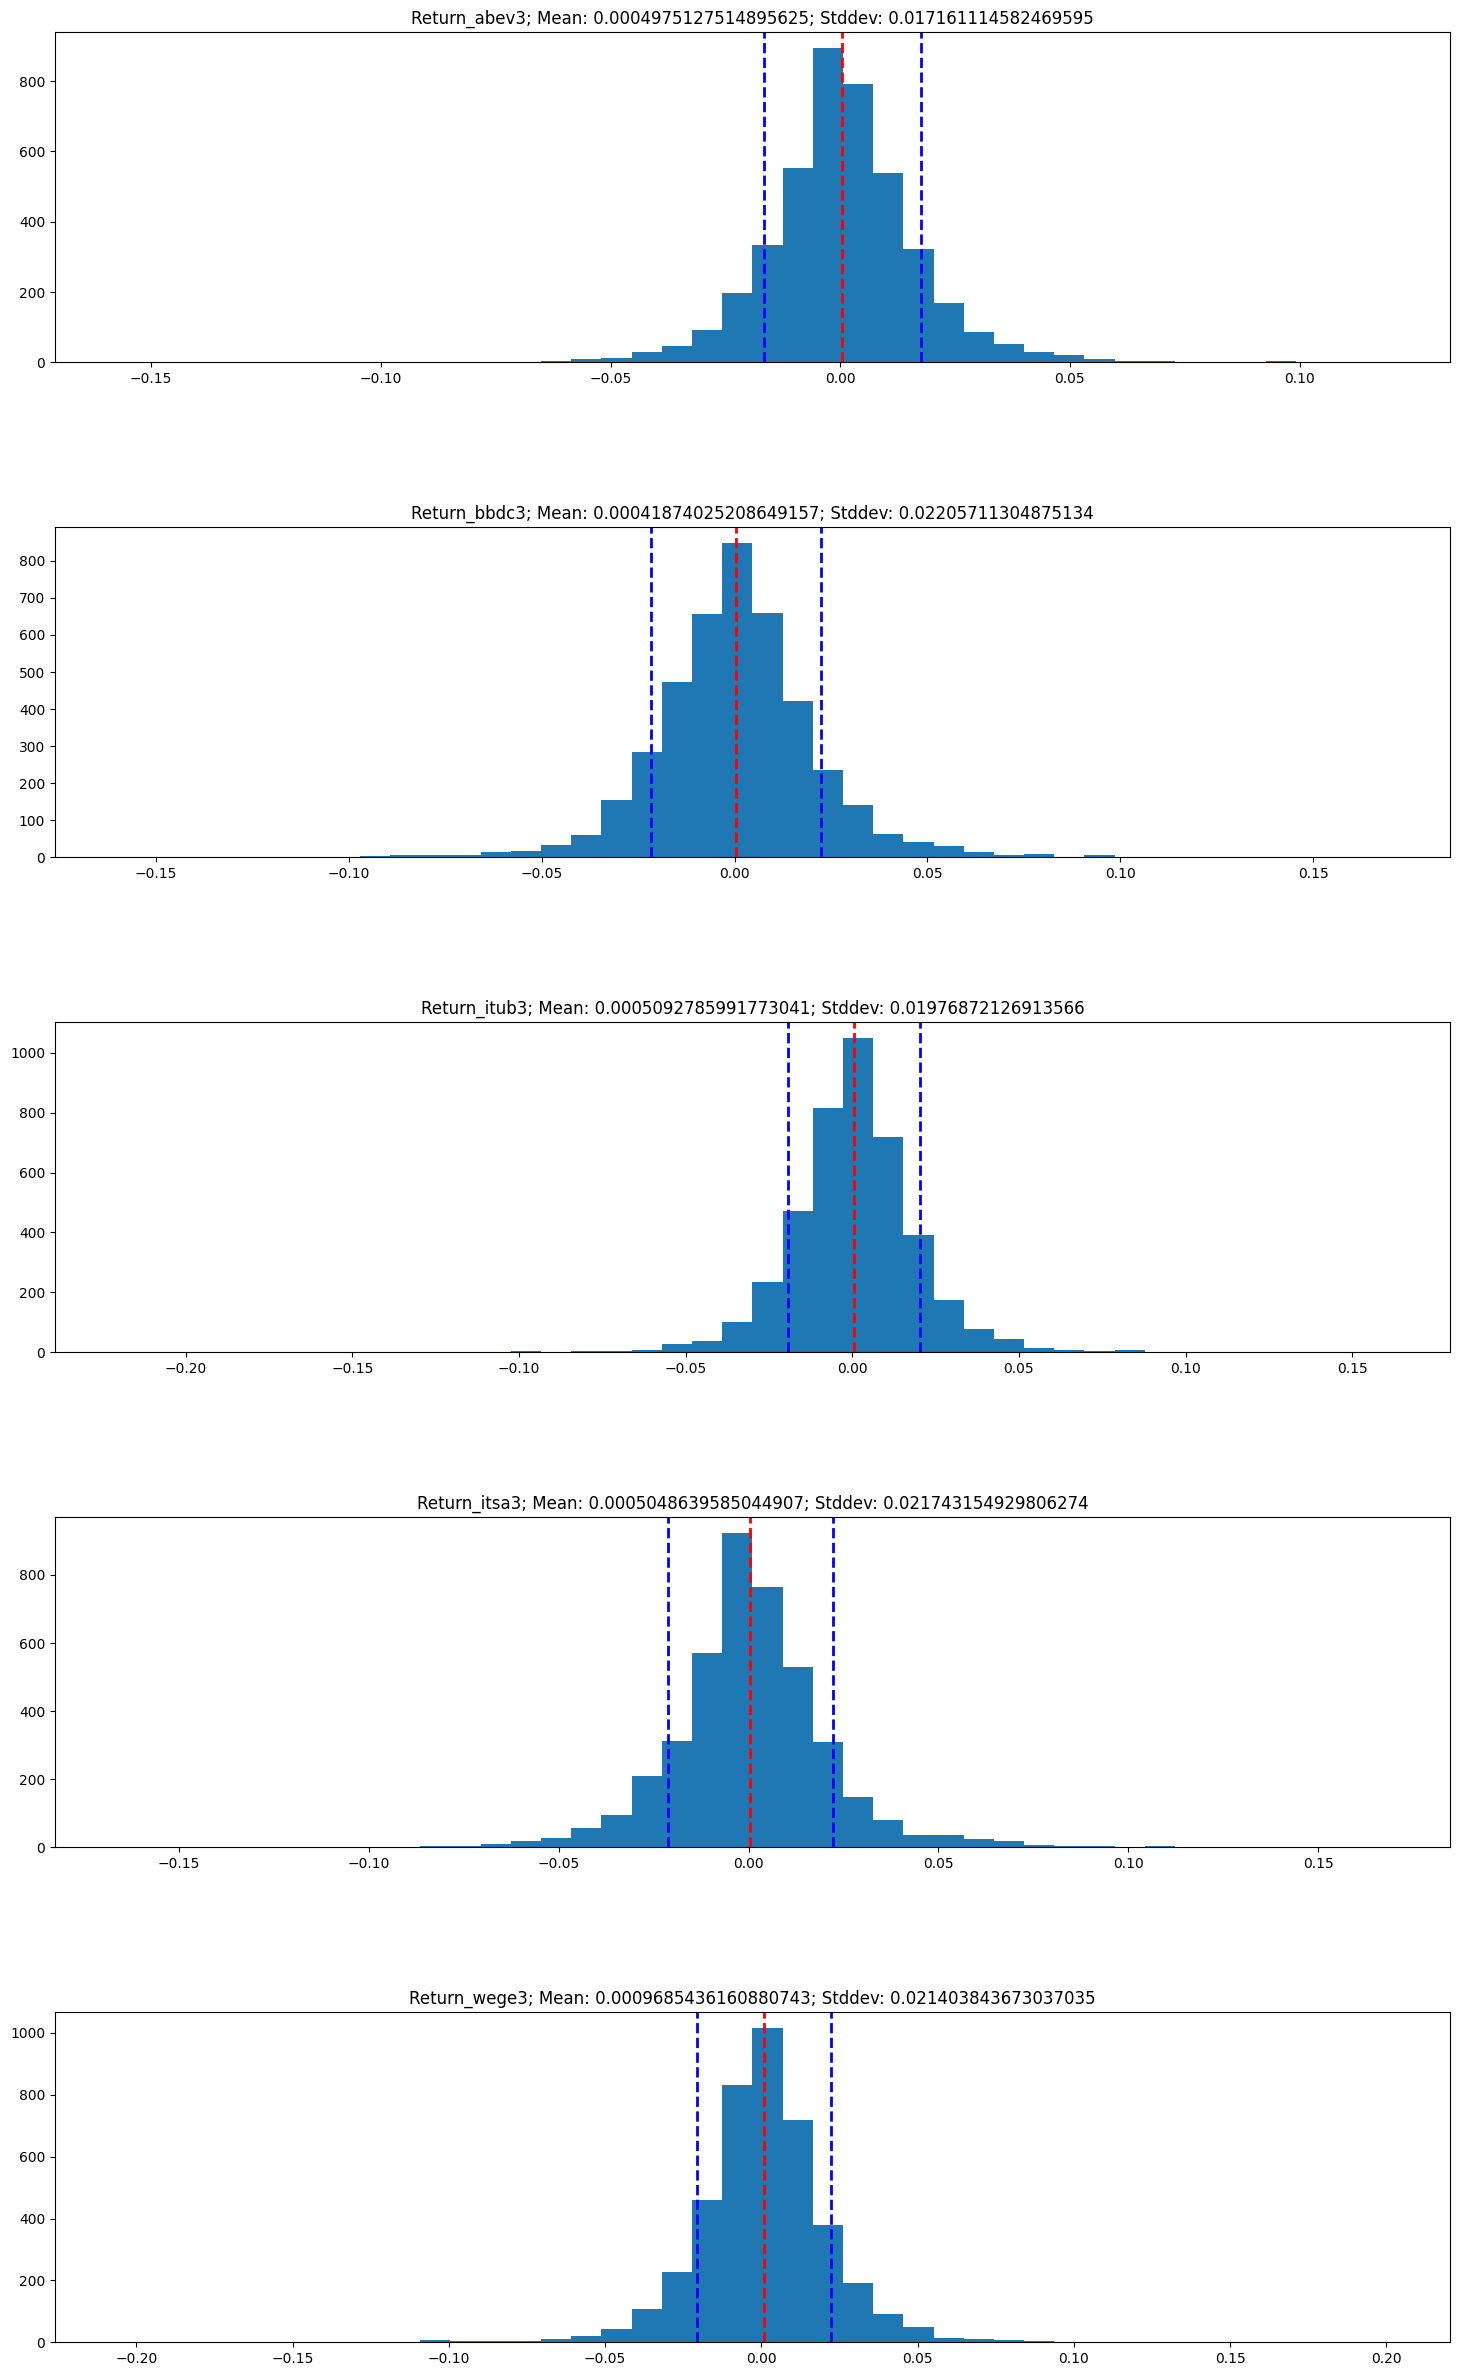

In [110]:
plt.figure(figsize=(18, 30))
for i, col in enumerate([col for col in stocks_df.columns.tolist() if "Return_" in col]):

    mean = np.array(stocks_df[col]).mean()
    std = np.array(stocks_df[col]).std()

    plt.subplot(5, 1, i+1)
    plt.axis(True)
    plt.hist(stocks_df[col], bins=math.floor(len(stocks_df)/100))
    plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
    plt.axvline(mean + std, color='blue', linestyle='dashed', linewidth=2, label=f'Mean + 1 Std Dev: {mean + std:.2f}')
    plt.axvline(mean - std, color='blue', linestyle='dashed', linewidth=2, label=f'Mean - 1 Std Dev: {mean - std:.2f}')
    plt.title(f"{col}; Mean: {mean}; Stddev: {std}")
    plt.subplots_adjust(wspace=0.2, hspace=0.5)

TODO: ver correlação entre series e intraseries

In [111]:
return_cols_names = filter(lambda x: "Return_" in x, stocks_df.columns.tolist())
stocks_df[return_cols_names].describe()

Return_abev3  Return_bbdc3  Return_itub3  Return_itsa3  Return_wege3
count   4211.000000   4211.000000   4211.000000   4211.000000   4211.000000
mean       0.000498      0.000419      0.000509      0.000505      0.000969
std        0.017163      0.022060      0.019771      0.021746      0.021406
min       -0.157168     -0.159763     -0.220203     -0.165992     -0.205761
25%       -0.008318     -0.011242     -0.009860     -0.010506     -0.010100
50%        0.000000      0.000000      0.000000      0.000000      0.000000
75%        0.009434      0.011498      0.010580      0.010674      0.011955
max        0.118919      0.169014      0.160271      0.167989      0.200000

As séries de retornos são todas estacionárias e não seguem uma distribuição normal, de acordo com o teste ADF e o teste de Shapiro-Wilk, com uma média ligeiramente inclinada para o lado positivo. A média positiva indica que essas séries geraram retornos positivos com mais frequência do que negativos, e comprar e manter essas ações durante esse período resultaria, ao final, em um resultado financeiro positivo. Todas as séries têm outliers bem acima e abaixo dos limites, o que pode estar influenciando o teste de Shapiro-Wilk

TODO: avaliar isso

In [112]:
all_stocks_performance = stocks_df["Price_abev3"] + stocks_df["Price_bbdc3"] + stocks_df["Price_itub3"] + stocks_df["Price_itsa3"] + stocks_df["Price_wege3"]
px.line(all_stocks_performance)

In [113]:
all_stocks_vec = np.array(all_stocks_performance)

(all_stocks_vec[-1] / all_stocks_vec[0])

5.30668983492615

# Experiments

In [114]:
def print_metrics(y_pred, y_true, title):
    print(f"prediction accuracy for {title}: {accuracy_score(y_true, y_pred)}")
    print(f"prediction precision for {title}: {precision_score(y_true, y_pred)}")
    print(f"prediction recall for {title}: {recall_score(y_true, y_pred)}")
    print(f"prediction f1 for {title}: {f1_score(y_true, y_pred)}")

# Building Dataframe

TODO: documentar funcoes

In [115]:
def compute_lags(df: pd.DataFrame, column_names: list[str], lags: int = 5):
    for col in column_names:
        if "Return" in col:
            for i in range(lags - 1):
                df[f"{col}_lag_{i+1}"] = df[f"{col}"].shift(i+1)

In [116]:
def compute_targets(df: pd.DataFrame, column_names: list[str]):
    df["Cross_sectional_median"] = np.median(df[[col for col in column_names if "Return" in col and not "lag" in col and not "Class" in col]].to_numpy(), axis=1)

    df["abev3_y"] = df["Return_abev3"].shift(-1) > df["Cross_sectional_median"].shift(-1)
    df["bbdc3_y"] = df["Return_bbdc3"].shift(-1) > df["Cross_sectional_median"].shift(-1)
    df["itsa3_y"] = df["Return_itsa3"].shift(-1) > df["Cross_sectional_median"].shift(-1)
    df["itub3_y"] = df["Return_itub3"].shift(-1) > df["Cross_sectional_median"].shift(-1)
    df["wege3_y"] = df["Return_wege3"].shift(-1) > df["Cross_sectional_median"].shift(-1)

In [117]:
compute_targets(stocks_df, stocks_df.columns.tolist())
stocks_df.head(15)

Price_abev3  Price_bbdc3  Price_itub3  Price_itsa3  Price_wege3  \
Date                                                                          
2007-10-11         3.08         6.20         7.87         3.43         2.44   
2007-10-15         3.02         6.09         7.75         3.43         2.47   
2007-10-16         2.94         5.97         7.61         3.48         2.47   
2007-10-17         3.06         6.09         7.86         3.48         2.57   
2007-10-18         3.07         6.09         7.69         3.48         2.59   
2007-10-19         3.00         6.09         7.52         3.43         2.57   
2007-10-22         3.00         6.13         7.57         3.50         2.54   
2007-10-23         3.00         6.19         7.70         3.38         2.58   
2007-10-24         3.00         6.23         7.59         3.46         2.65   
2007-10-25         2.95         6.09         7.44         3.45         2.66   
2007-10-26         2.97         6.30         7.71         3.45         2.70   
2007-10-29         2.99         6.29         7.87         3.40         2.74   
2007-10-30         3.03         6.21         7.76         3.43         2.75   
2007-10-31         3.08         6.36         7.87         3.43         2.84   
2007-11-01         3.09         6.03         7.61         3.44         2.87   

            Return_abev3  Return_bbdc3  Return_itub3  Return_itsa3  \
Date                                                                 
2007-10-11      0.013158     -0.023622     -0.034356      0.000000   
2007-10-15     -0.019481     -0.017742     -0.015248      0.000000   
2007-10-16     -0.026490     -0.019704     -0.018065      0.014577   
2007-10-17      0.040816      0.020101      0.032852      0.000000   
2007-10-18      0.003268      0.000000     -0.021628      0.000000   
2007-10-19     -0.022801      0.000000     -0.022107     -0.014368   
2007-10-22      0.000000      0.006568      0.006649      0.020408   
2007-10-23      0.000000      0.009788      0.017173     -0.034286   
2007-10-24      0.000000      0.006462     -0.014286      0.023669   
2007-10-25     -0.016667     -0.022472     -0.019763     -0.002890   
2007-10-26      0.006780      0.034483      0.036290      0.000000   
2007-10-29      0.006734     -0.001587      0.020752     -0.014493   
2007-10-30      0.013378     -0.012719     -0.013977      0.008824   
2007-10-31      0.016502      0.024155      0.014175      0.000000   
2007-11-01      0.003247     -0.051887     -0.033037      0.002915   

            Return_wege3  Cross_sectional_median  abev3_y  bbdc3_y  itsa3_y  \
Date                                                                          
2007-10-11      0.004115                0.000000    False    False     True   
2007-10-15      0.012295               -0.015248    False    False     True   
2007-10-16      0.000000               -0.018065     True    False    False   
2007-10-17      0.040486                0.032852     True    False    False   
2007-10-18      0.007782                0.000000    False     True    False   
2007-10-19     -0.007722               -0.014368    False    False     True   
2007-10-22     -0.011673                0.006568    False    False    False   
2007-10-23      0.015748                0.009788    False    False     True   
2007-10-24      0.027132                0.006462    False    False     True   
2007-10-25      0.003774               -0.016667    False     True    False   
2007-10-26      0.015038                0.015038    False    False    False   
2007-10-29      0.014815                0.006734     True    False     True   
2007-10-30      0.003650                0.003650    False     True    False   
2007-10-31      0.032727                0.016502     True    False    False   
2007-11-01      0.010563                0.002915    False     True    False   

            itub3_y  wege3_y  
Date                          
2007-10-11    False     True  
2007-10-15    False     True  
2007-10-1

In [118]:
compute_lags(stocks_df, stocks_df.columns.tolist())

stocks_df.head()

Price_abev3  Price_bbdc3  Price_itub3  Price_itsa3  Price_wege3  \
Date                                                                          
2007-10-11         3.08         6.20         7.87         3.43         2.44   
2007-10-15         3.02         6.09         7.75         3.43         2.47   
2007-10-16         2.94         5.97         7.61         3.48         2.47   
2007-10-17         3.06         6.09         7.86         3.48         2.57   
2007-10-18         3.07         6.09         7.69         3.48         2.59   

            Return_abev3  Return_bbdc3  Return_itub3  Return_itsa3  \
Date                                                                 
2007-10-11      0.013158     -0.023622     -0.034356      0.000000   
2007-10-15     -0.019481     -0.017742     -0.015248      0.000000   
2007-10-16     -0.026490     -0.019704     -0.018065      0.014577   
2007-10-17      0.040816      0.020101      0.032852      0.000000   
2007-10-18      0.003268      0.000000     -0.021628      0.000000   

            Return_wege3  ...  Return_itub3_lag_3  Return_itub3_lag_4  \
Date                      ...                                           
2007-10-11      0.004115  ...                 NaN                 NaN   
2007-10-15      0.012295  ...                 NaN                 NaN   
2007-10-16      0.000000  ...                 NaN                 NaN   
2007-10-17      0.040486  ...           -0.034356                 NaN   
2007-10-18      0.007782  ...           -0.015248           -0.034356   

            Return_itsa3_lag_1  Return_itsa3_lag_2  Return_itsa3_lag_3  \
Date                                                                     
2007-10-11                 NaN                 NaN                 NaN   
2007-10-15            0.000000                 NaN                 NaN   
2007-10-16            0.000000            0.000000                 NaN   
2007-10-17            0.014577            0.000000                 0.0   
2007-10-18            0.000000            0.014577                 0.0   

            Return_itsa3_lag_4  Return_wege3_lag_1  Return_wege3_lag_2  \
Date                                                                     
2007-10-11                 NaN                 NaN                 NaN   
2007-10-15                 NaN            0.004115                 NaN   
2007-10-16                 NaN            0.012295            0.004115   
2007-10-17                 NaN            0.000000            0.012295   
2007-10-18                 0.0            0.040486            0.000000   

            Return_wege3_lag_3  Return_wege3_lag_4  
Date                                                
2007-10-11                 NaN                 NaN  
2007-10-15                 NaN                 NaN  
2007-10-16                 NaN                 NaN  
2007-10-17            0.004115                 NaN  
2007-10-18            0.012295            0.004115  

[5 rows x 36 columns]

In [119]:
stocks_df[[col for col in stocks_df.columns.tolist() if "abev3" in col]].head()

Price_abev3  Return_abev3  abev3_y  Return_abev3_lag_1  \
Date                                                                 
2007-10-11         3.08      0.013158    False                 NaN   
2007-10-15         3.02     -0.019481    False            0.013158   
2007-10-16         2.94     -0.026490     True           -0.019481   
2007-10-17         3.06      0.040816     True           -0.026490   
2007-10-18         3.07      0.003268    False            0.040816   

            Return_abev3_lag_2  Return_abev3_lag_3  Return_abev3_lag_4  
Date                                                                    
2007-10-11                 NaN                 NaN                 NaN  
2007-10-15                 NaN                 NaN                 NaN  
2007-10-16            0.013158                 NaN                 NaN  
2007-10-17           -0.019481            0.013158                 NaN  
2007-10-18           -0.026490           -0.019481            0.013158

# Baseline Experiments

Add referencia argumentando pro classificacao

In [120]:
stocks_df[[col for col in stocks_df.columns.tolist() if "abev3" in col or "median" in col]].head(10)

Price_abev3  Return_abev3  Cross_sectional_median  abev3_y  \
Date                                                                     
2007-10-11         3.08      0.013158                0.000000    False   
2007-10-15         3.02     -0.019481               -0.015248    False   
2007-10-16         2.94     -0.026490               -0.018065     True   
2007-10-17         3.06      0.040816                0.032852     True   
2007-10-18         3.07      0.003268                0.000000    False   
2007-10-19         3.00     -0.022801               -0.014368    False   
2007-10-22         3.00      0.000000                0.006568    False   
2007-10-23         3.00      0.000000                0.009788    False   
2007-10-24         3.00      0.000000                0.006462    False   
2007-10-25         2.95     -0.016667               -0.016667    False   

            Return_abev3_lag_1  Return_abev3_lag_2  Return_abev3_lag_3  \
Date                                                                     
2007-10-11                 NaN                 NaN                 NaN   
2007-10-15            0.013158                 NaN                 NaN   
2007-10-16           -0.019481            0.013158                 NaN   
2007-10-17           -0.026490           -0.019481            0.013158   
2007-10-18            0.040816           -0.026490           -0.019481   
2007-10-19            0.003268            0.040816           -0.026490   
2007-10-22           -0.022801            0.003268            0.040816   
2007-10-23            0.000000           -0.022801            0.003268   
2007-10-24            0.000000            0.000000           -0.022801   
2007-10-25            0.000000            0.000000            0.000000   

            Return_abev3_lag_4  
Date                            
2007-10-11                 NaN  
2007-10-15                 NaN  
2007-10-16                 NaN  
2007-10-17                 NaN  
2007-10-18            0.013158  
2007-10-19           -0.019481  
2007-10-22           -0.026490  
2007-10-23            0.040816  
2007-10-24            0.003268  
2007-10-25           -0.022801

In [121]:
def preprocess_rf(data: pd.DataFrame, stock_name: str) -> pd.DataFrame:
    # remove na
    # filter stock
    # remove price
    data = data[[col for col in data.columns.tolist() if stock_name in col or "median" in col]].copy()
    data = data.drop(f"Price_{stock_name}", axis=1)
    data = data.dropna(axis=0)

    return data

preprocess_rf(stocks_df, "abev3").head()

Return_abev3  Cross_sectional_median  abev3_y  Return_abev3_lag_1  \
Date                                                                            
2007-10-18      0.003268                0.000000    False            0.040816   
2007-10-19     -0.022801               -0.014368    False            0.003268   
2007-10-22      0.000000                0.006568    False           -0.022801   
2007-10-23      0.000000                0.009788    False            0.000000   
2007-10-24      0.000000                0.006462    False            0.000000   

            Return_abev3_lag_2  Return_abev3_lag_3  Return_abev3_lag_4  
Date                                                                    
2007-10-18           -0.026490           -0.019481            0.013158  
2007-10-19            0.040816           -0.026490           -0.019481  
2007-10-22            0.003268            0.040816           -0.026490  
2007-10-23           -0.022801            0.003268            0.040816  
2007-10-24            0.000000           -0.022801            0.003268

In [122]:
train_size = 240
test_size = 30

def sliding_window_cv(data, train_size, test_size, stock_name, model, preprocessing_func):
    data = preprocessing_func(data, stock_name)
    n_samples = len(data)
    # y = data["Return_abev3"]
    count_folds = 0

    tests = []
    yhats = []
    
    for start in range(0, n_samples - train_size - test_size + 1, test_size):
        count_folds += 1
        train = data.iloc[start : start + train_size]
        train_X = train.drop([f"Return_{stock_name}", f"{stock_name}_y"], axis=1)
        train_y = train.filter([f"{stock_name}_y"])

        test = data.iloc[start + train_size : start + train_size + test_size]
        test_X = test.drop([f"Return_{stock_name}", f"{stock_name}_y"], axis=1)
        test_y = test.filter([f"{stock_name}_y"])

        tests.append(test_y)

        model.fit(train_X, np.array(train_y))
        yhats.append(model.predict(test_X))

        if start in range(0, 100):
            plt.figure(figsize=(20, 7))
            plt.plot(y.index, y, 'b-', label = 'actual')
            plt.plot(test.index, test_X, 'ro', label = 'testing')
            plt.plot(train.index, train_X, 'yo', label = 'training')
            plt.legend()
            plt.plot()
        
        # start = start + test_size

    print(f"total fold count: {count_folds}")

    all_accuracies = [accuracy_score(tests[i], yhats[i]) for i in range(len(tests))]
    return np.mean(all_accuracies)

# sliding_window_cv(stocks_df, train_size, test_size, "abev3", )

## Define Cross Validation Splitter

In [123]:
class SlidingWindowExclusiveTestCV(BaseCrossValidator):
    def __init__(self, train_size: int, val_size: int):
        self.train_size = train_size
        self.val_size = val_size

    def get_n_splits(self, X=None, y=None, groups=None):
        """
        On a CV splitter (not an estimator), returns the number of elements one would get if iterating through 
        the return value of split given the same parameters. Takes the same parameters as split.
        """
        n_samples = len(X)
        count = 0
        for _ in range(0, n_samples - self.train_size - self.val_size + 1, self.val_size):
            count += 1
        return count

    def split(self, X=None, y=None, groups=None):
        """
        On a CV splitter (not an estimator), this method accepts parameters (X, y, groups), where all may be optional, 
        and returns an iterator over (train_idx, test_idx) pairs. Each of {train,test}_idx is a 1d integer array, 
        with values from 0 from X.shape[0] - 1 of any length, such that no values appear in both some train_idx and 
        its corresponding test_idx.
        """
        n_samples = len(X)
        for start in range(0, n_samples - self.train_size - self.val_size + 1, self.val_size):
            # print(start)
            train_indices = np.arange(start, start + self.train_size)
            test_indices = np.arange(start + self.train_size, start + self.train_size + self.val_size)
            yield train_indices, test_indices

In [124]:
def check_time_index_overlap(dataframes):
    # Convert each DataFrame's index to a set for faster intersection checking
    index_sets = [set(df.index) for df in dataframes]
    
    # Check each pair of DataFrames for overlap
    for i in range(len(index_sets)):
        for j in range(i + 1, len(index_sets)):
            if index_sets[i].intersection(index_sets[j]):
                print(f"Overlap found between DataFrame {i} and DataFrame {j}")
                return True

    print("No overlap found; all time indices are mutually exclusive.")
    return False

No overlap found; all time indices are mutually exclusive.


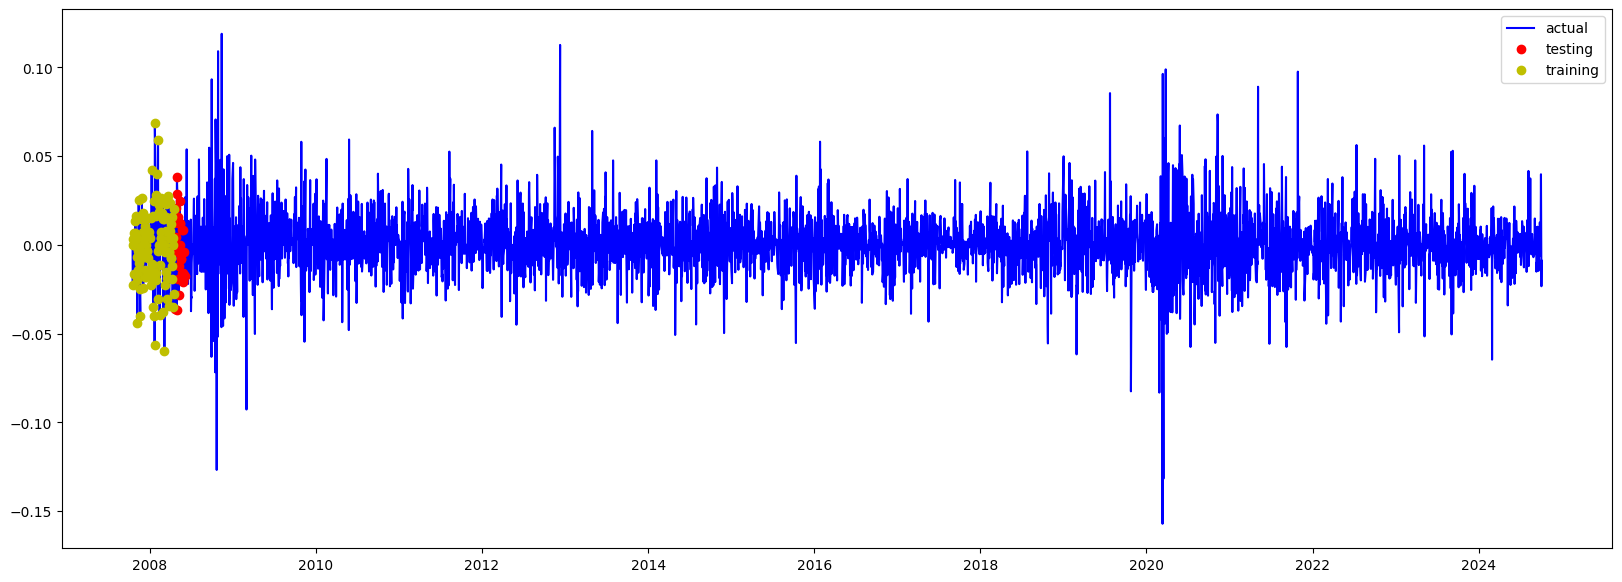

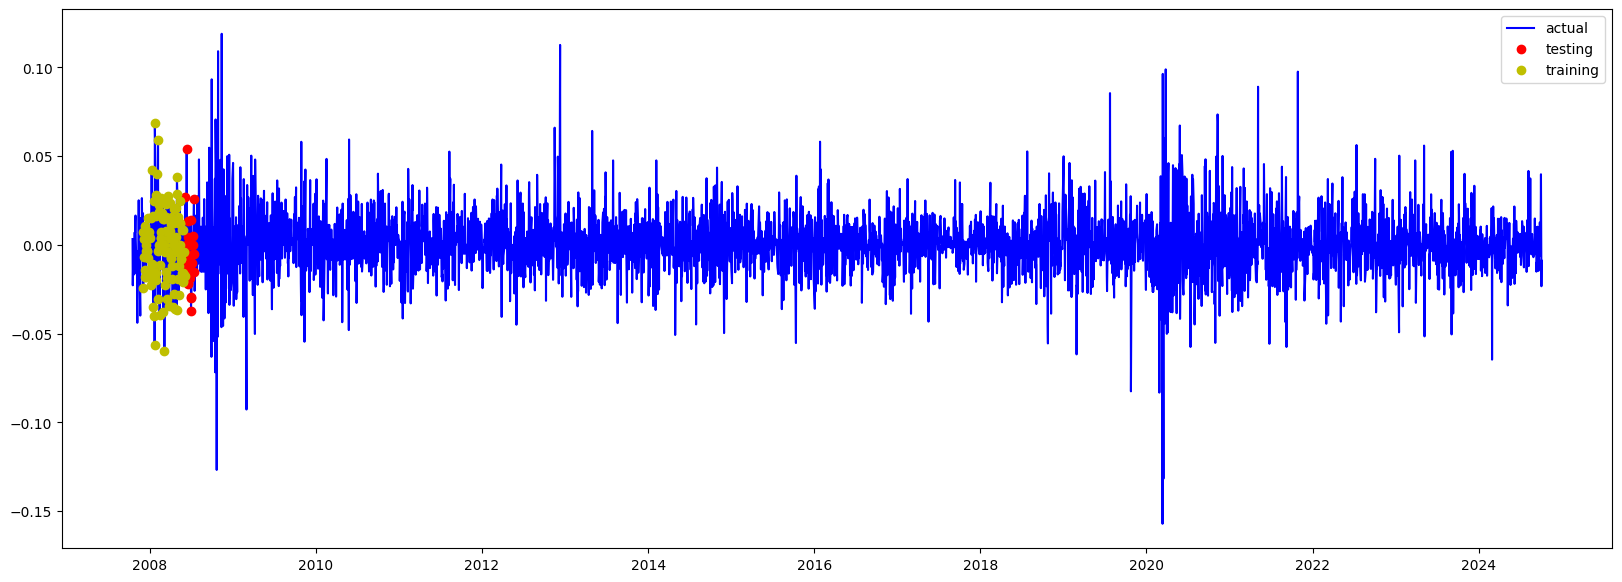

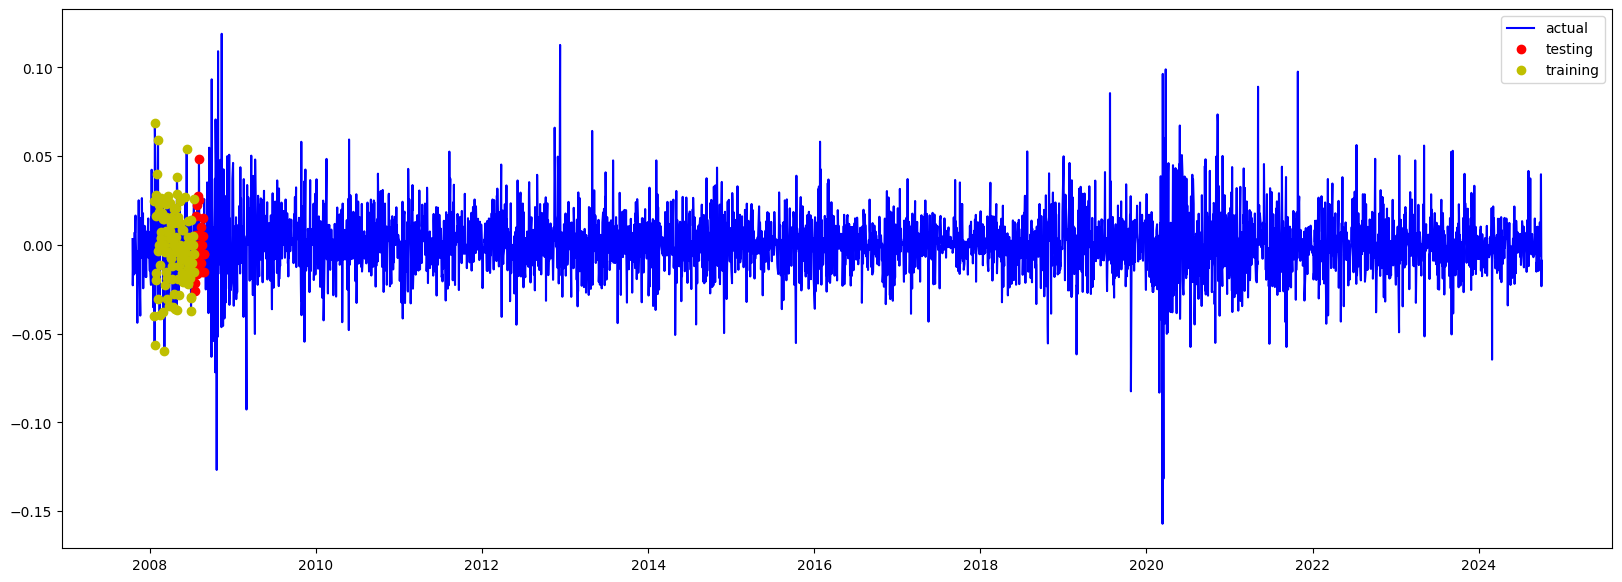

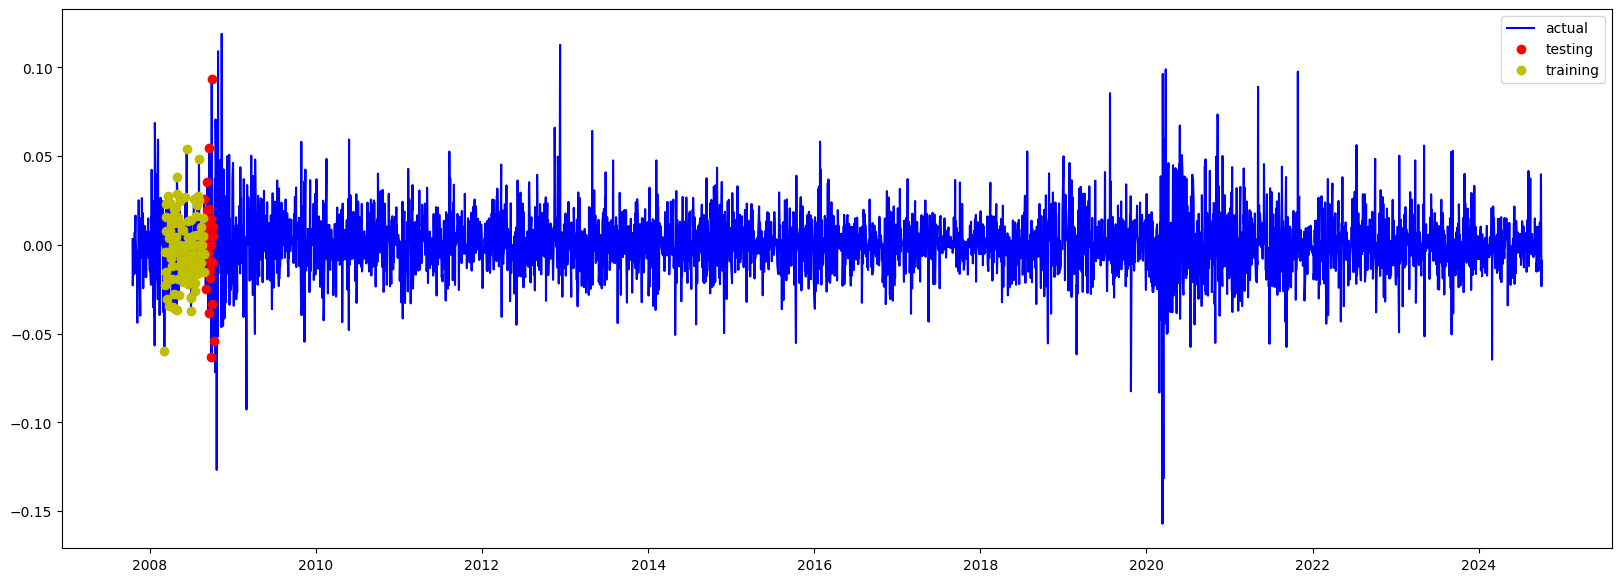

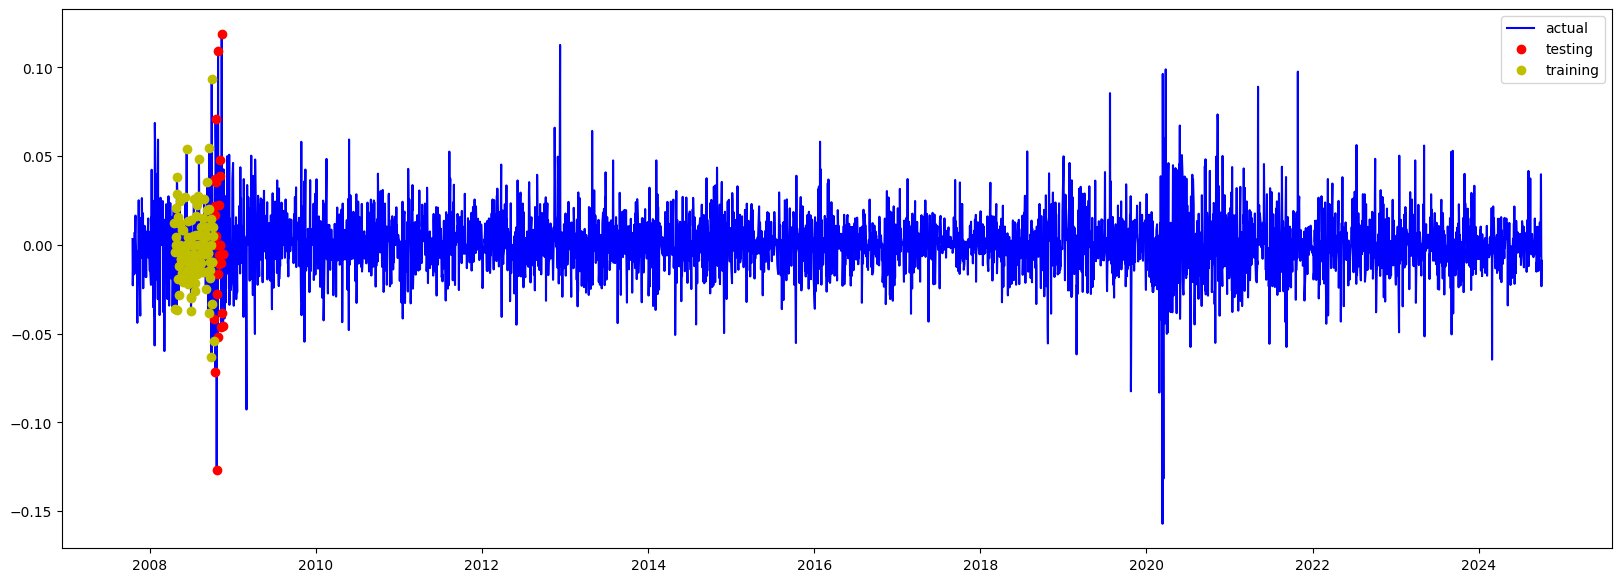

In [125]:
cv = SlidingWindowExclusiveTestCV(120, 30)

count = 0

tests = []
trains = []

df = preprocess_rf(stocks_df, "abev3")

for train_index, test_index in cv.split(df["Return_abev3"]):
    X_train, X_test = df["Return_abev3"].iloc[train_index], df["Return_abev3"].iloc[test_index]

    tests.append(X_test)
    trains.append(X_train)

    # if count == 0 or count % 10 == 0:
    if count in range(5):
        plt.figure(figsize=(20, 7))
        # plt.title(regression_metrics(y_test, y_test_pred))
        plt.plot(df.index, df["Return_abev3"], 'b-', label = 'actual')
        plt.plot(X_test.index, X_test, 'ro', label = 'testing')
        plt.plot(X_train.index, X_train, 'yo', label = 'training')
        plt.legend()
        plt.plot()

    count += 1

assert check_time_index_overlap(tests) == False
assert type(tests[0]) == pd.Series
assert trains[0].index[0] == df["Return_abev3"].index[0]

In [126]:
tests[0].index[-1], tests[1].index[0], tests[1].index[-1], tests[2].index[0], tests[2].index[-1], tests[3].index[0]

(Timestamp('2008-06-03 00:00:00'),
 Timestamp('2008-06-04 00:00:00'),
 Timestamp('2008-07-16 00:00:00'),
 Timestamp('2008-07-17 00:00:00'),
 Timestamp('2008-08-27 00:00:00'),
 Timestamp('2008-08-28 00:00:00'))

In [127]:
trains[1].index[-1], tests[1].index[0], trains[2].index[-1], tests[2].index[0], trains[3].index[-1], tests[3].index[0]

(Timestamp('2008-06-03 00:00:00'),
 Timestamp('2008-06-04 00:00:00'),
 Timestamp('2008-07-16 00:00:00'),
 Timestamp('2008-07-17 00:00:00'),
 Timestamp('2008-08-27 00:00:00'),
 Timestamp('2008-08-28 00:00:00'))

treino e teste nao aparentam estar vazando um no outro

In [128]:
def print_simple_metrics(results):
    accs = [i["accuracy"] for i in results]
    print(np.array(accs).mean())

    f1 = [i["f1"] for i in results]
    print(np.array(f1).mean())

    precisions = [i["precision"] for i in results]
    print(np.array(precisions).mean())

    recalls = [i["recall"] for i in results]
    print(np.array(recalls).mean())

## LSTM

In [129]:
LSTM_NUM_EXPERIMENTS = 1
LSTM_HIDDEN_UNITS = 128

TRAIN_SIZE = 240
VAL_SIZE = 30

In [130]:
def define_lstm(data_shape, num_units):
    lstm = Sequential()

    lstm.add(Input(shape=data_shape))
    lstm.add(LSTM(num_units))
    lstm.add(Dense(1, activation="sigmoid"))

    lstm.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    return lstm

In [131]:
def preprocess_lstm(data: pd.DataFrame, stock_name: str) -> pd.DataFrame:
    # remove na
    # filter stock
    # remove price
    # standardize
    data = data[[col for col in data.columns.tolist() if stock_name in col]].copy()
    data = data.drop(f"Price_{stock_name}", axis=1)
    data = data.dropna(axis=0)

    return data

In [132]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=25,
    restore_best_weights=True,
	mode='max'
)

def run_n_lstm_experiments(n_exps: int, train_size: int, val_size: int, stock: str, num_units: int):
    all_runs_tests = []
    results = []

    for i in range(n_exps):
        np.random.seed(i)
        random.seed(i)
        tf.random.set_seed(i)

        data = preprocess_rf(stocks_df, stock)

        X = data.drop([f"{stock}_y"], axis=1)
        y_ground = data[f"{stock}_y"]

        model = define_lstm((X.shape[1], 1), num_units)
        cv_splitter = SlidingWindowExclusiveTestCV(train_size, val_size)

        tests = []

        for train_index, test_index in cv_splitter.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y_ground.iloc[train_index], y_ground.iloc[test_index]

            # tests.append(X_test)
            trains.append(X_train)

            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.fit_transform(X_test)

            history = model.fit(
                X_train, y_train,
                epochs = 750,
                batch_size=1,
                # validation_data=(X_test, y_test),
                validation_split=0.2,
                callbacks=[early_stopping],
                shuffle=False,
                verbose=False
            )

            # results.append(history.history)

            y_hat = model.predict(X_test, verbose=False)

            y_hat = np.array(y_hat)
            for i in range(len(y_hat)):
                if y_hat[i] > 0.5:
                    y_hat[i] = True
                else:
                    y_hat[i] = False

            for i, y in enumerate(y_hat):
                tests.append({y_test.index[i]: y})
                
            results.append({
                "accuracy": accuracy_score(y_test, y_hat),
                "f1": f1_score(y_test, y_hat),
                "precision": precision_score(y_test, y_hat, zero_division=0),
                "recall": recall_score(y_test, y_hat)
            })
        
        all_runs_tests.append(tests)

    # all_accs.append(np.array(accs).mean())
    np.random.seed(RANDOM_STATE)
    random.seed(RANDOM_STATE)
    tf.random.set_seed(RANDOM_STATE)

    return results, all_runs_tests

In [133]:
abev3_lstm_res, abev3_preds = run_n_lstm_experiments(
    LSTM_NUM_EXPERIMENTS, 
    TRAIN_SIZE, 
    VAL_SIZE, 
    "abev3", 
    LSTM_HIDDEN_UNITS
)
abev3_lstm_res = [i["accuracy"] for i in abev3_lstm_res]
np.array(abev3_lstm_res).mean()

0.5391414141414143

In [134]:
abev3_preds[0][-1]

{Timestamp('2024-09-25 00:00:00'): array([1.], dtype=float32)}

In [135]:
bbdc3_lstm_res, bbdc3_preds = run_n_lstm_experiments(
    LSTM_NUM_EXPERIMENTS, 
    TRAIN_SIZE, 
    VAL_SIZE, 
    "bbdc3", 
    LSTM_HIDDEN_UNITS
)
bbdc3_lstm_res = [i["accuracy"] for i in bbdc3_lstm_res]
np.array(bbdc3_lstm_res).mean()

0.6212121212121212

In [136]:
itsa3_lstm_res, itsa3_preds = run_n_lstm_experiments(
    LSTM_NUM_EXPERIMENTS, 
    TRAIN_SIZE, 
    VAL_SIZE, 
    "itsa3", 
    LSTM_HIDDEN_UNITS
)
itsa3_lstm_res = [i["accuracy"] for i in itsa3_lstm_res]
np.array(itsa3_lstm_res).mean()

0.5931818181818183

In [137]:
itub3_lstm_res, itub3_preds = run_n_lstm_experiments(
    LSTM_NUM_EXPERIMENTS, 
    TRAIN_SIZE, 
    VAL_SIZE, 
    "itub3", 
    LSTM_HIDDEN_UNITS
)
itub3_lstm_res = [i["accuracy"] for i in itub3_lstm_res]
np.array(itub3_lstm_res).mean()

0.6219696969696971

In [138]:
wege3_lstm_res, wege3_preds = run_n_lstm_experiments(
    LSTM_NUM_EXPERIMENTS, 
    TRAIN_SIZE, 
    VAL_SIZE, 
    "wege3", 
    LSTM_HIDDEN_UNITS
)
wege3_lstm_res = [i["accuracy"] for i in wege3_lstm_res]
np.array(wege3_lstm_res).mean()

0.5666666666666667

## Comparing portfolio

In [139]:
return_cols = [col for col in stocks_df.columns.tolist() if "Return" in col and "lag" not in col]
return_cols

['Return_abev3',
 'Return_bbdc3',
 'Return_itub3',
 'Return_itsa3',
 'Return_wege3']

In [140]:
list(abev3_preds[0][0].keys())[0], list(bbdc3_preds[0][0].keys())[0], list(itsa3_preds[0][0].keys())[0], list(wege3_preds[0][0].keys())[0]

(Timestamp('2008-10-09 00:00:00'),
 Timestamp('2008-10-09 00:00:00'),
 Timestamp('2008-10-09 00:00:00'),
 Timestamp('2008-10-09 00:00:00'))

In [141]:
list(abev3_preds[0][-1].keys())[0], list(bbdc3_preds[0][-1].keys())[0], list(itsa3_preds[0][-1].keys())[0], list(wege3_preds[0][-1].keys())[0]

(Timestamp('2024-09-25 00:00:00'),
 Timestamp('2024-09-25 00:00:00'),
 Timestamp('2024-09-25 00:00:00'),
 Timestamp('2024-09-25 00:00:00'))

In [142]:
start_date = list(abev3_preds[0][0].keys())[0]
end_date = list(abev3_preds[0][-1].keys())[0]

In [143]:
daily_returns = stocks_df[return_cols].loc[start_date : end_date]
daily_returns

Return_abev3  Return_bbdc3  Return_itub3  Return_itsa3  \
Date                                                                 
2008-10-09     -0.041667     -0.095238     -0.052910      0.010989   
2008-10-10      0.000000     -0.016620     -0.065177     -0.105072   
2008-10-13      0.021739      0.169014      0.075697      0.093117   
2008-10-14      0.037234      0.050602      0.020370      0.066667   
2008-10-15     -0.071795     -0.080275     -0.032668      0.000000   
...                  ...           ...           ...           ...   
2024-09-19     -0.002311     -0.010279     -0.007190      0.006312   
2024-09-20     -0.014672     -0.017062     -0.015743     -0.022401   
2024-09-23     -0.000784     -0.024151     -0.001599     -0.008249   
2024-09-24      0.000784     -0.004640     -0.002884      0.001848   
2024-09-25     -0.006270     -0.012432      0.009319      0.011070   

            Return_wege3  
Date                      
2008-10-09     -0.092199  
2008-10-10     -0.101563  
2008-10-13      0.200000  
2008-10-14      0.072464  
2008-10-15     -0.060811  
...                  ...  
2024-09-19     -0.001877  
2024-09-20     -0.013912  
2024-09-23      0.034318  
2024-09-24      0.019724  
2024-09-25      0.005242  

[3960 rows x 5 columns]

In [144]:
# Define portfolio weights (example: equal weights for each stock)
weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

# Calculate daily portfolio returns
portfolio_returns = daily_returns.dot(weights)

# Calculate cumulative returns
cumulative_returns = (1 + portfolio_returns).cumprod()

# Convert to DataFrame for plotting
cumulative_returns_df = pd.DataFrame({'Cumulative Return': cumulative_returns}, index=daily_returns.index)

# Plot using Plotly Express
fig = px.line(cumulative_returns_df, y='Cumulative Return', title='Portfolio Cumulative Performance Over Time')
fig.show()

In [145]:
daily_returns

Return_abev3  Return_bbdc3  Return_itub3  Return_itsa3  \
Date                                                                 
2008-10-09     -0.041667     -0.095238     -0.052910      0.010989   
2008-10-10      0.000000     -0.016620     -0.065177     -0.105072   
2008-10-13      0.021739      0.169014      0.075697      0.093117   
2008-10-14      0.037234      0.050602      0.020370      0.066667   
2008-10-15     -0.071795     -0.080275     -0.032668      0.000000   
...                  ...           ...           ...           ...   
2024-09-19     -0.002311     -0.010279     -0.007190      0.006312   
2024-09-20     -0.014672     -0.017062     -0.015743     -0.022401   
2024-09-23     -0.000784     -0.024151     -0.001599     -0.008249   
2024-09-24      0.000784     -0.004640     -0.002884      0.001848   
2024-09-25     -0.006270     -0.012432      0.009319      0.011070   

            Return_wege3  
Date                      
2008-10-09     -0.092199  
2008-10-10     -0.101563  
2008-10-13      0.200000  
2008-10-14      0.072464  
2008-10-15     -0.060811  
...                  ...  
2024-09-19     -0.001877  
2024-09-20     -0.013912  
2024-09-23      0.034318  
2024-09-24      0.019724  
2024-09-25      0.005242  

[3960 rows x 5 columns]

In [146]:
inclusion_mask = pd.DataFrame({
    'Return_abev3': pd.Series([list(val.values())[0][0] for val in abev3_preds[0]], index=[list(val.keys())[0] for val in abev3_preds[0]]),
    'Return_bbdc3': pd.Series([list(val.values())[0][0] for val in bbdc3_preds[0]], index=[list(val.keys())[0] for val in bbdc3_preds[0]]),
    'Return_itsa3': pd.Series([list(val.values())[0][0] for val in itsa3_preds[0]], index=[list(val.keys())[0] for val in itsa3_preds[0]]),
    'Return_itub3': pd.Series([list(val.values())[0][0] for val in itub3_preds[0]], index=[list(val.keys())[0] for val in itub3_preds[0]]),
    'Return_wege3': pd.Series([list(val.values())[0][0] for val in wege3_preds[0]], index=[list(val.keys())[0] for val in wege3_preds[0]]),
})

# Apply mask to daily returns
adjusted_returns = daily_returns * inclusion_mask.shift(-1)
adjusted_returns = adjusted_returns.dropna(axis=0)
adjusted_returns

# # Step 4: Adjust weights based on inclusion mask
effective_weights = inclusion_mask * weights  # Set weight to 0 for excluded stocks

# # Normalize weights so they sum up to 1 for each day
normalized_weights = effective_weights.div(effective_weights.sum(axis=1), axis=0).fillna(0)

# # Step 5: Calculate daily portfolio returns with adjusted weights
portfolio_returns = (adjusted_returns * effective_weights).sum(axis=1)

# # Step 6: Calculate cumulative returns
cumulative_returns_pred = (1 + portfolio_returns).cumprod()

# # Convert to DataFrame for plotting
cumulative_returns_pred_df = pd.DataFrame({'Cumulative Return': cumulative_returns_pred}, index=daily_returns.index)

# # Plot using Plotly Express
fig = px.line(cumulative_returns_pred_df, y='Cumulative Return', title='Portfolio Cumulative Performance Over Time')
fig.show()

[]

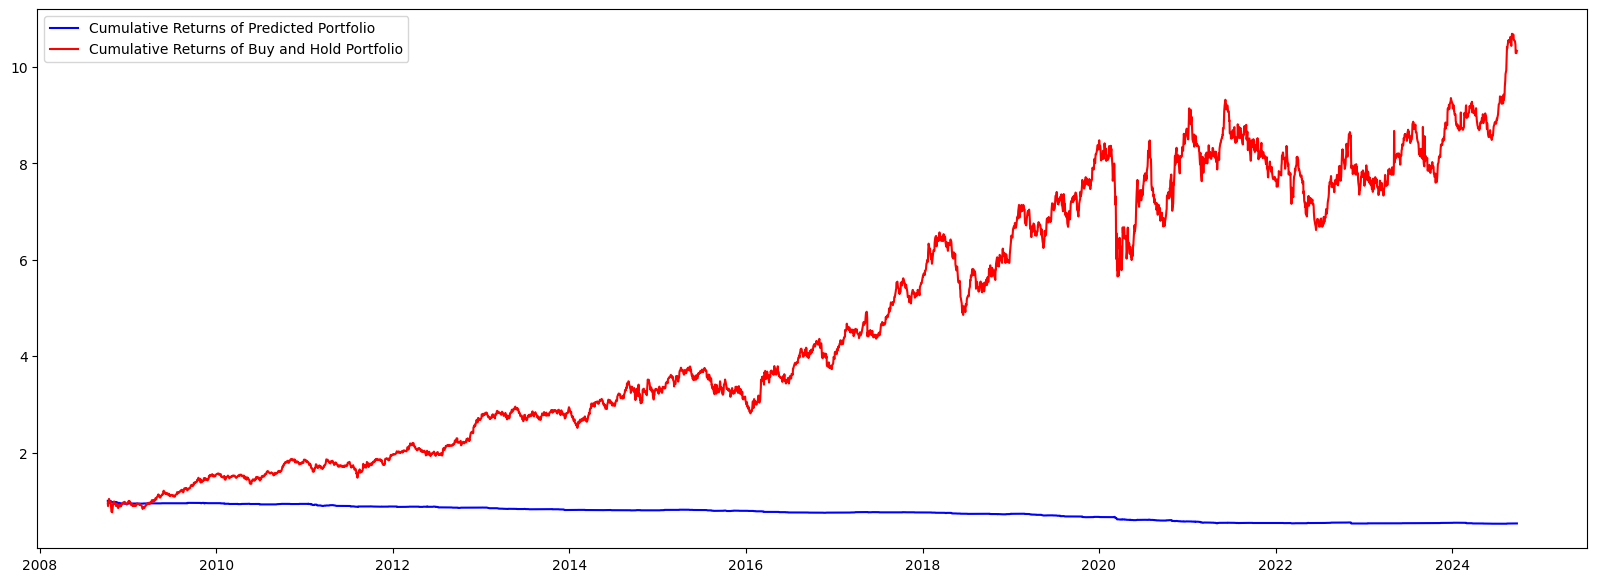

In [147]:
plt.figure(figsize=(20, 7))
plt.plot(daily_returns.index, cumulative_returns_pred, 'b-', label = 'Cumulative Returns of Predicted Portfolio')
plt.plot(daily_returns.index, cumulative_returns, 'r-', label = 'Cumulative Returns of Buy and Hold Portfolio')
# plt.plot(X_test.index, X_test, 'ro', label = 'testing')
# plt.plot(X_train.index, X_train, 'yo', label = 'training')
plt.legend()
plt.plot()

## Exp 2

In [148]:
LSTM_HIDDEN_UNITS_2 = 16

In [149]:
abev3_lstm_res2, abev3_preds2 = run_n_lstm_experiments(
    LSTM_NUM_EXPERIMENTS, 
    TRAIN_SIZE, 
    VAL_SIZE, 
    "abev3", 
    LSTM_HIDDEN_UNITS_2
)
abev3_lstm_res2 = [i["accuracy"] for i in abev3_lstm_res2]
np.array(abev3_lstm_res2).mean()

0.5939393939393939

In [150]:
bbdc3_lstm_res2, bbdc3_preds2 = run_n_lstm_experiments(
    LSTM_NUM_EXPERIMENTS, 
    TRAIN_SIZE, 
    VAL_SIZE, 
    "bbdc3", 
    LSTM_HIDDEN_UNITS_2
)
bbdc3_lstm_res2 = [i["accuracy"] for i in bbdc3_lstm_res2]
np.array(bbdc3_lstm_res2).mean()

0.6270202020202021

In [151]:
itsa3_lstm_res2, itsa3_preds2 = run_n_lstm_experiments(
    LSTM_NUM_EXPERIMENTS, 
    TRAIN_SIZE, 
    VAL_SIZE, 
    "itsa3", 
    LSTM_HIDDEN_UNITS_2
)
itsa3_lstm_res2 = [i["accuracy"] for i in itsa3_lstm_res2]
np.array(itsa3_lstm_res2).mean()

0.593939393939394

In [152]:
itub3_lstm_res2, itub3_preds2 = run_n_lstm_experiments(
    LSTM_NUM_EXPERIMENTS, 
    TRAIN_SIZE, 
    VAL_SIZE, 
    "itub3", 
    LSTM_HIDDEN_UNITS_2
)
itub3_lstm_res2 = [i["accuracy"] for i in itub3_lstm_res2]
np.array(itub3_lstm_res2).mean()

0.6222222222222221

In [153]:
wege3_lstm_res2, wege3_preds2 = run_n_lstm_experiments(
    LSTM_NUM_EXPERIMENTS, 
    TRAIN_SIZE, 
    VAL_SIZE, 
    "wege3", 
    LSTM_HIDDEN_UNITS_2
)
wege3_lstm_res2 = [i["accuracy"] for i in wege3_lstm_res2]
np.array(wege3_lstm_res2).mean()

0.570959595959596

In [154]:
inclusion_mask = pd.DataFrame({
    'Return_abev3': pd.Series([list(val.values())[0][0] for val in abev3_preds2[0]], index=[list(val.keys())[0] for val in abev3_preds2[0]]),
    'Return_bbdc3': pd.Series([list(val.values())[0][0] for val in bbdc3_preds2[0]], index=[list(val.keys())[0] for val in bbdc3_preds2[0]]),
    'Return_itsa3': pd.Series([list(val.values())[0][0] for val in itsa3_preds2[0]], index=[list(val.keys())[0] for val in itsa3_preds2[0]]),
    'Return_itub3': pd.Series([list(val.values())[0][0] for val in itub3_preds2[0]], index=[list(val.keys())[0] for val in itub3_preds2[0]]),
    'Return_wege3': pd.Series([list(val.values())[0][0] for val in wege3_preds2[0]], index=[list(val.keys())[0] for val in wege3_preds2[0]]),
})

# Apply mask to daily returns
adjusted_returns = daily_returns * inclusion_mask.shift(-1)
adjusted_returns = adjusted_returns.dropna(axis=0)
adjusted_returns

# # Step 4: Adjust weights based on inclusion mask
effective_weights = inclusion_mask * weights  # Set weight to 0 for excluded stocks

# # Normalize weights so they sum up to 1 for each day
normalized_weights = effective_weights.div(effective_weights.sum(axis=1), axis=0).fillna(0)

# # Step 5: Calculate daily portfolio returns with adjusted weights
portfolio_returns = (adjusted_returns * effective_weights).sum(axis=1)

# # Step 6: Calculate cumulative returns
cumulative_returns_pred = (1 + portfolio_returns).cumprod()

# # Convert to DataFrame for plotting
cumulative_returns_pred_df = pd.DataFrame({'Cumulative Return': cumulative_returns_pred}, index=daily_returns.index)

# # Plot using Plotly Express
fig = px.line(cumulative_returns_pred_df, y='Cumulative Return', title='Portfolio Cumulative Performance Over Time')
fig.show()

[]

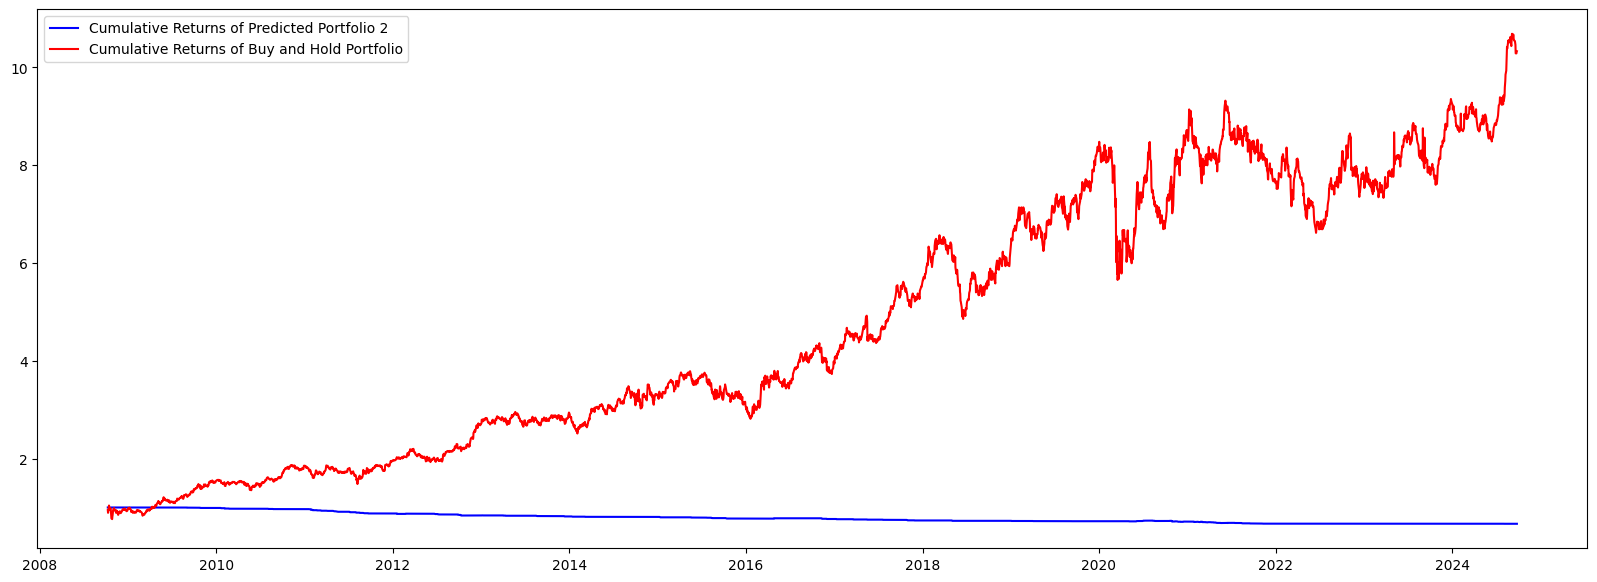

In [155]:
plt.figure(figsize=(20, 7))
plt.plot(daily_returns.index, cumulative_returns_pred, 'b-', label = 'Cumulative Returns of Predicted Portfolio 2')
plt.plot(daily_returns.index, cumulative_returns, 'r-', label = 'Cumulative Returns of Buy and Hold Portfolio')
# plt.plot(X_test.index, X_test, 'ro', label = 'testing')
# plt.plot(X_train.index, X_train, 'yo', label = 'training')
plt.legend()
plt.plot()

## Exp 3

In [156]:
LSTM_HIDDEN_UNITS_3 = 8
TRAIN_SIZE_3 = 240

In [157]:
abev3_lstm_res3, abev3_preds3 = run_n_lstm_experiments(
    LSTM_NUM_EXPERIMENTS, 
    TRAIN_SIZE_3, 
    VAL_SIZE, 
    "abev3", 
    LSTM_HIDDEN_UNITS_3
)
abev3_lstm_res3 = [i["accuracy"] for i in abev3_lstm_res3]
np.array(abev3_lstm_res3).mean()

0.5949494949494949

In [158]:
bbdc3_lstm_res3, bbdc3_preds3 = run_n_lstm_experiments(
    LSTM_NUM_EXPERIMENTS, 
    TRAIN_SIZE_3, 
    VAL_SIZE, 
    "bbdc3", 
    LSTM_HIDDEN_UNITS_3
)
bbdc3_lstm_res3 = [i["accuracy"] for i in bbdc3_lstm_res3]
np.array(bbdc3_lstm_res3).mean()

0.6292929292929292

In [159]:
itsa3_lstm_res3, itsa3_preds3 = run_n_lstm_experiments(
    LSTM_NUM_EXPERIMENTS, 
    TRAIN_SIZE_3, 
    VAL_SIZE, 
    "itsa3", 
    LSTM_HIDDEN_UNITS_3
)
itsa3_lstm_res3 = [i["accuracy"] for i in itsa3_lstm_res3]
np.array(itsa3_lstm_res3).mean()

0.5916666666666667

In [160]:
itub3_lstm_res3, itub3_preds3 = run_n_lstm_experiments(
    LSTM_NUM_EXPERIMENTS, 
    TRAIN_SIZE_3, 
    VAL_SIZE, 
    "itub3", 
    LSTM_HIDDEN_UNITS_3
)
itub3_lstm_res3 = [i["accuracy"] for i in itub3_lstm_res3]
np.array(itub3_lstm_res3).mean()

0.6214646464646465

In [161]:
wege3_lstm_res3, wege3_preds3 = run_n_lstm_experiments(
    LSTM_NUM_EXPERIMENTS, 
    TRAIN_SIZE_3, 
    VAL_SIZE, 
    "wege3", 
    LSTM_HIDDEN_UNITS_3
)
wege3_lstm_res3 = [i["accuracy"] for i in wege3_lstm_res3]
np.array(wege3_lstm_res3).mean()

0.5686868686868687

In [162]:
inclusion_mask = pd.DataFrame({
    'Return_abev3': pd.Series([list(val.values())[0][0] for val in abev3_preds3[0]], index=[list(val.keys())[0] for val in abev3_preds3[0]]),
    'Return_bbdc3': pd.Series([list(val.values())[0][0] for val in bbdc3_preds3[0]], index=[list(val.keys())[0] for val in bbdc3_preds3[0]]),
    'Return_itsa3': pd.Series([list(val.values())[0][0] for val in itsa3_preds3[0]], index=[list(val.keys())[0] for val in itsa3_preds3[0]]),
    'Return_itub3': pd.Series([list(val.values())[0][0] for val in itub3_preds3[0]], index=[list(val.keys())[0] for val in itub3_preds3[0]]),
    'Return_wege3': pd.Series([list(val.values())[0][0] for val in wege3_preds3[0]], index=[list(val.keys())[0] for val in wege3_preds3[0]]),
})

# Apply mask to daily returns
adjusted_returns = daily_returns * inclusion_mask.shift(-1)
adjusted_returns = adjusted_returns.dropna(axis=0)
adjusted_returns

# # Step 4: Adjust weights based on inclusion mask
effective_weights = inclusion_mask * weights  # Set weight to 0 for excluded stocks

# # Normalize weights so they sum up to 1 for each day
normalized_weights = effective_weights.div(effective_weights.sum(axis=1), axis=0).fillna(0)

# # Step 5: Calculate daily portfolio returns with adjusted weights
portfolio_returns = (adjusted_returns * effective_weights).sum(axis=1)

# # Step 6: Calculate cumulative returns
cumulative_returns_pred = (1 + portfolio_returns).cumprod()

# # Convert to DataFrame for plotting
cumulative_returns_pred_df = pd.DataFrame({'Cumulative Return': cumulative_returns_pred}, index=daily_returns.index)

# # Plot using Plotly Express
fig = px.line(cumulative_returns_pred_df, y='Cumulative Return', title='Portfolio Cumulative Performance Over Time')
fig.show()